# Modelo ARIMA para BTC y ETH
Se supone un modelo aditivo.

X(t) = T(t) + S(t) + E(t)

T(t) -> Componente de tendencia

S(t) -> Componente de estacionalidad

E(t) -> Componente irregular o aleatoria

In [140]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.arima_model import ARIMA
plt.rcParams['figure.dpi'] = 150
sns.set()

### Kolmogorov-Zurbenko filter implementation

In [7]:

# -*- coding: utf-8 -*-

# kolzur_filter module - NumPy implementation of the Kolmogorov-Zurbenko filter
# Copyright (C) 2017  Mathieu Schopfer
#
# This program is free software: you can redistribute it and/or modify
# it under the terms of the GNU General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.
#
# This program is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
# GNU General Public License for more details.
#
# You should have received a copy of the GNU General Public License
# along with this program.  If not, see <http://www.gnu.org/licenses/>.


"""Numpy implementation of the Kolmogorov-Zurbenko filter
https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Zurbenko_filter
.. todo:: Implement the KZ adaptive filter.
"""

import numpy as np

__author__ = 'Mathieu Schopfer'
__version__ = '2017-03-31'


def sliding_window(arr, window):
    """Apply a sliding window on a numpy array.
    :param numpy.ndarray arr: An array of shape `(n1, ..., nN)`
    :param int window: Window size.
    :return: A :class:`numpy.ndarray` of shape `(n1, ..., nN-window+1, window)`.
    .. seealso:: Source http://stackoverflow.com/a/6811241/3849212
    Usage (1D):
    .. doctest::
        >>> arr = np.arange(10)
        >>> arrs = sliding_window(arr, 5)
        >>> arrs.shape
        (6, 5)
        >>> print(arrs[0])
        [0 1 2 3 4]
        >>> print(arrs[1])
        [1 2 3 4 5]
    Usage (2D):
    .. doctest::
        >>> arr = np.arange(20).reshape(2, 10)
        >>> arrs = sliding_window(arr, 5)
        >>> arrs.shape
        (2, 6, 5)
        >>> print(arrs[0, 0])
        [0 1 2 3 4]
        >>> print(arrs[0, 1])
        [1 2 3 4 5]
    """

    # Advanced numpy tricks
    shape = arr.shape[:-1] + (arr.shape[-1]-window+1, window)
    strides = arr.strides + (arr.strides[-1],)
    return np.lib.stride_tricks.as_strided(arr, shape=shape, strides=strides)


def _kz_coeffs(m, k):
    """Calculate coefficients of the Kolmogorov–Zurbenko filter
    :return: A :class:`numpy.ndarray` of size `k*(m-1)+1`
    This functions returns the normlalised coefficients :math:`a_s^{m,k}/m^k`.
    .. rubric:: Coefficients definition
    A definition of the Kolmogorov–Zurbenko filter coefficients is provided in `this article
    <http://onlinelibrary.wiley.com/doi/10.1002/wics.71/pdf>`_. Coefficients :math:`a_s^{m,k}`  are
    the coefficients of the polynomial function:
    .. math::
        (1 + z + \\cdots + z^{m-1})^k = \\sum_{s=-k(m-1)/2}^{k(m-1)/2} a_s^{m,k} \\cdot z^{s+k(m-1)/2}
    The :math:`a_s^{m,k}` coefficients are calculated by iterating over :math:`k`.
    .. rubric:: Calculation example for m=5 and k=3
    Let us define the polynomial function
    .. math::
        P(z) = 1 + z + z^2 + z^3 + z^4.
    At :math:`k=1`, the coefficients :math:`a_s^{m,k}=a_s^{1,5}` are that of :math:`P(z)`, 
    .. math::
        \\left(\\begin{matrix}
        1 & 1 & 1 & 1 & 1
        \\end{matrix}\\right).
    At :math:`k=2`, we want to calculate the coefficients of polynomial function :math:`P(z)\\cdot P(z)`, of degree 8.
    First, we calculate the polynomial functions :math:`P(z)`, :math:`zP(z)`, :math:`z^2P(z)` and :math:`z^3P(z)` and
    then sum them.
    Let us represent the coefficients of these functions in a table, with monomial elements in columns:
    .. math::
        \\begin{array}{r|ccccccccc}
        & z^0 & z^1 & z^2 & z^3 & z^4 & z^5 & z^6 & z^7 & z^8 \\\\
        \\hline
        P(z)    & 1 & 1 & 1 & 1 & 1 & 0 & 0 & 0 & 0 \\\\
        zP(z)   & 0 & 1 & 1 & 1 & 1 & 1 & 0 & 0 & 0 \\\\
        z^2P(z) & 0 & 0 & 1 & 1 & 1 & 1 & 1 & 0 & 0 \\\\
        z^3P(z) & 0 & 0 & 1 & 1 & 1 & 1 & 1 & 1 & 0 \\\\
        z^4P(z) & 0 & 0 & 0 & 1 & 1 & 1 & 1 & 1 & 1 \\\\
        \\hline
        \\mathrm{Sum} & 1 & 2 & 3 & 4 & 5 & 4 & 3 & 2 & 1
        \\end{array}
    At :math:`k=3`, we want to calculate the coefficients of polynomial function :math:`P(z)\\cdot P(z)^2`, of degree
    12. We use the same representation:
    .. math::
        \\begin{array}{r|ccccccccccccc}
        & z^0 & z^1 & z^2 & z^3 & z^4 & z^5 & z^6 & z^7 & z^8 & z^9 & z^{10} & z^{11} & z^{12} \\\\
        \\hline
        P(z)^2    & 1 & 2 & 3 & 4 & 5 & 4 & 3 & 2 & 1 & 0 & 0 & 0 & 0 \\\\
        zP(z)^2   & 0 & 1 & 2 & 3 & 4 & 5 & 4 & 3 & 2 & 1 & 0 & 0 & 0 \\\\
        z^2P(z)^2 & 0 & 0 & 1 & 2 & 3 & 4 & 5 & 4 & 3 & 2 & 1 & 0 & 0 \\\\
        z^3P(z)^2 & 0 & 0 & 0 & 1 & 2 & 3 & 4 & 5 & 4 & 3 & 2 & 1 & 0 \\\\
        z^4P(z)^2 & 0 & 0 & 0 & 0 & 1 & 2 & 3 & 4 & 5 & 4 & 3 & 2 & 1 \\\\
        \\hline
        \\mathrm{Sum} & 1 & 3 & 6 & 10 & 15 & 18 & 19 & 18 & 15 & 10 & 6 & 3 & 1
        \\end{array}
    .. doctest::
        >>> c = _kz_coeffs(3, 1)
        >>> print(c)
        [ 0.33333333  0.33333333  0.33333333]
        >>> c = _kz_coeffs(3, 2)
        >>> print(c*3**2)
        [ 1.  2.  3.  2.  1.]
        >>> c = _kz_coeffs(5, 3)
        >>> print(c*5**3)
        [  1.   3.   6.  10.  15.  18.  19.  18.  15.  10.   6.   3.   1.]
    """

    # Coefficients at degree one
    coef = np.ones(m)

    # Iterate k-1 times over coefficients
    for i in range(1, k):

        t = np.zeros((m, m+i*(m-1)))
        for km in range(m):
            t[km, km:km+coef.size] = coef

        coef = np.sum(t, axis=0)

    assert coef.size == k*(m-1)+1

    return coef/m**k


def _kz_prod(data, coef, m, k, t=None):

    n = data.size
    data = sliding_window(data, k*(m-1)+1)
    assert data.shape == (n-k*(m-1), len(coef))

    # Restrict KZ product calculation to provided indices
    if t is not None:
        data = data[t]
        assert data.shape == (len(t), len(coef))

    return data*coef


def _kz_sum(data, coef):

    knan = np.isnan(data)

    # Handle missing values if any
    if np.any(knan):

        coef = np.ma.MaskedArray(np.broadcast_to(coef[np.newaxis, :], data.shape), mask=knan)
        coef = np.sum(coef, axis=-1)

        data = np.nansum(data, axis=-1)

        # Restore nan were data are missing
        data[coef.mask] = np.nan

        # Divide by coefficients sum, which may not be 1
        k = np.logical_not(coef.mask)
        data[k] = data[k]/coef[k]

        return data

    else:
        return np.sum(data, axis=-1)


def kz_filter(data, m, k):
    """Kolmogorov-Zurbenko fitler
    :param numpy.ndarray data: A 1-dimensional numpy array of size `N`. Any missing value should be set to ``np.nan``.
    :param int m: Filter window width.
    :param int k: Filter degree.
    :return: A :class:`numpy.ndarray` of size `N-k*(m-1)`
    Given a time series :math:`X_t, t \\in \\{0, 1, \\cdots, N-1\\}`, the Kolmogorov-Zurbenko fitler is defined for
    :math:`t \\in \\{\\frac{k(m-1)}{2}, \\cdots, N-1-\\frac{k(m-1)}{2}\\}` by
    .. math::
        KZ_{m,k}[X_t] = \\sum_{s=-k(m-1)/2}^{k(m-1)/2} \\frac{a_s^{m,k}}{m^k} \\cdot X_{t+s}
    Definition of coefficients :math:`a_s^{m,k}` is given in :func:`_kz_coeffs`.
    """

    coef = _kz_coeffs(m, k)
    data = _kz_prod(data, coef, m, k)

    return _kz_sum(data, coef)


def kzft(data, nu, m, k, t=None, dt=1.):
    """Kolmogorov-Zurbenko Fourier transform filter
    :param numpy.ndarray data: A 1-dimensional numpy array of size `N`. Any missing value should be set to ``np.nan``.
    :param list-like nu: Frequencies, length `Nnu`.
    :param int m: Filter window width.
    :param int k: Filter degree.
    :param list-like t: Calculation indices, of length `Nt`. If provided, KZFT filter will be calculated only for values
      ``data[t]``. Note that the KZFT filter can only be calculated for indices in the range [k(m-1)/2, (N-1)-k(m-1)/2].
      Trying to calculate the KZFT out of this range will raise an `IndexError`. `None`, calculation will happen over
      the whole calculable range.
    :param float dt: Time step, if not 1.
    :return: A :class:`numpy.ndarray` of shape `(Nnu, Nt)` or `(Nnu, N-k(m-1))` if `t` is `None`.
    :raise IndexError: If `t` contains one or more indices out of the calculation range. See documentation of keyword
      argument `t`.
    Given a time series :math:`X_t, t \\in \\{0, 1, \\cdots, N-1\\}`, the Kolmogorov-Zurbenko Fourier transform filter
    is defined for :math:`t \\in \\{\\frac{k(m-1)}{2}, \\cdots, N-1-\\frac{k(m-1)}{2}\\}` by
    
    .. math::
        KZFT_{m,k,\\nu}[X_t] = \\sum_{s=-k(m-1)/2}^{k(m-1)/2} \\frac{a_s^{m,k}}{m^k} \\cdot X_{t+s} \\cdot
        e^{-2\\pi i\\nu s}
    """

    if not dt == 1.:
        nu = np.asarray(nu)*dt
        m = int((m-1)/dt+1)
        if not m%2:
            m += 1

    if t is not None:
        w = int(k*(m-1)/2)
        t = np.asarray(t)-w
        if np.any(t < 0) or np.any(t > (data.size-1-2*w)):
            raise IndexError('Inpunt calculation indices are out of range. Calculation indices should be in the range '
                             '[k*(m-1)/2, (N-1)-k*(m-1)/2], hence [{}, {}] in the present case.'
                             .format(w, data.size-1-w))

    coef = _kz_coeffs(m, k)
    data = _kz_prod(data, coef, m, k, t=t)

    nu = np.asarray(nu)
    s = k*(m-1)/2
    s = np.arange(-s, s+1)
    s = np.exp(-1j*2*np.pi*nu[:, np.newaxis]*s)

    data = data[np.newaxis]*s[:, np.newaxis]

    return _kz_sum(data, coef)


def kzp(data, nu, m, k, dt=1.):
    """Kolmogorov-Zurbenko periodogram
    :param numpy.ndarray data: A 1-dimensional numpy array of size `N`. Any missing value should be set to ``np.nan``.
    :param list-like nu: Frequencies, length `Nnu`.
    :param int m: Filter window width.
    :param int k: Filter degree.
    :param float dt: Time step, if not 1.
    :return: A :class:`numpy.ndarray` os size `Nnu`.
    Given a time series :math:`X_t, t \\in \\{0, 1, \\cdots, N-1\\}`, the Kolmogorov-Zurbenko periodogram is defined by
    .. math::
        KZP_{m,k}(\\nu) = \\sqrt{\\sum_{h=0}^{T-1} \\lvert 2 \\cdot  KZFT_{m,k,\\nu}[X_{hL+k(m-1)/2}] \\rvert ^2}
    where :math:`L=(N-w)/(T-1)` is the distance between the beginnings of two successive intervals, :math:`w` being the
    calculation window width of the :func:`kzft` and :math:`T` the number of intervals. 
    The assumption was made that :math:`L \\ll w \\ll N`, implying that the intervals overlap.
    """

    if not dt == 1.:
        nu = nu*dt
        m = int((m-1)/dt+1)
        if not m%2:
            m += 1

    # w is the width of the KZFT. As m is odd, k*(m-1) is always even, so w is always odd.
    w = k*(m-1)+1

    # Distance between two successve intervals
    l = int(m/10)
    nt = int((data.size-w)/l+1)

    # Calculation indices
    l = np.arange(nt-1)*l+k*(m-1)/2
    l = np.floor(l).astype(int)

    return np.sqrt(np.nanmean(np.square(2*np.abs(kzft(data, nu, m, k, t=l))), axis=-1))



# Data input

In [8]:
# Raw data
BTC = pd.read_csv('../data/bitcoin.csv', index_col='Date', parse_dates=True)
BTC_train = pd.read_csv('../data/bitcoin_train.csv', index_col='Date', parse_dates=True)
BTC_test  = pd.read_csv('../data/bitcoin_test.csv', index_col='Date', parse_dates=True)

ETH = pd.read_csv('../data/ethereum.csv', index_col='Date', parse_dates=True)
ETH_train = pd.read_csv('../data/ethereum_train.csv', index_col='Date', parse_dates=True)
ETH_test  = pd.read_csv('../data/ethereum_test.csv', index_col='Date', parse_dates=True)

# Series
BTC_serie = BTC[['Adj Close']]
BTC_train_serie = BTC_train[['Adj Close']]
BTC_test_serie = BTC_test[['Adj Close']]

ETH_serie = ETH[['Adj Close']]
ETH_train_serie = ETH_train[['Adj Close']]
ETH_test_serie = ETH_test[['Adj Close']]

# Datetime indexs
BTC_index = BTC.index
BTC_train_index = BTC_train.index
BTC_test_index = BTC_test.index

ETH.index = ETH.index
ETH_train_index = ETH_train.index
ETH_test_index = ETH_test.index

# Bitcoin ARIMA Model

## Representación train/test

/anaconda3/envs/cryptocurr/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


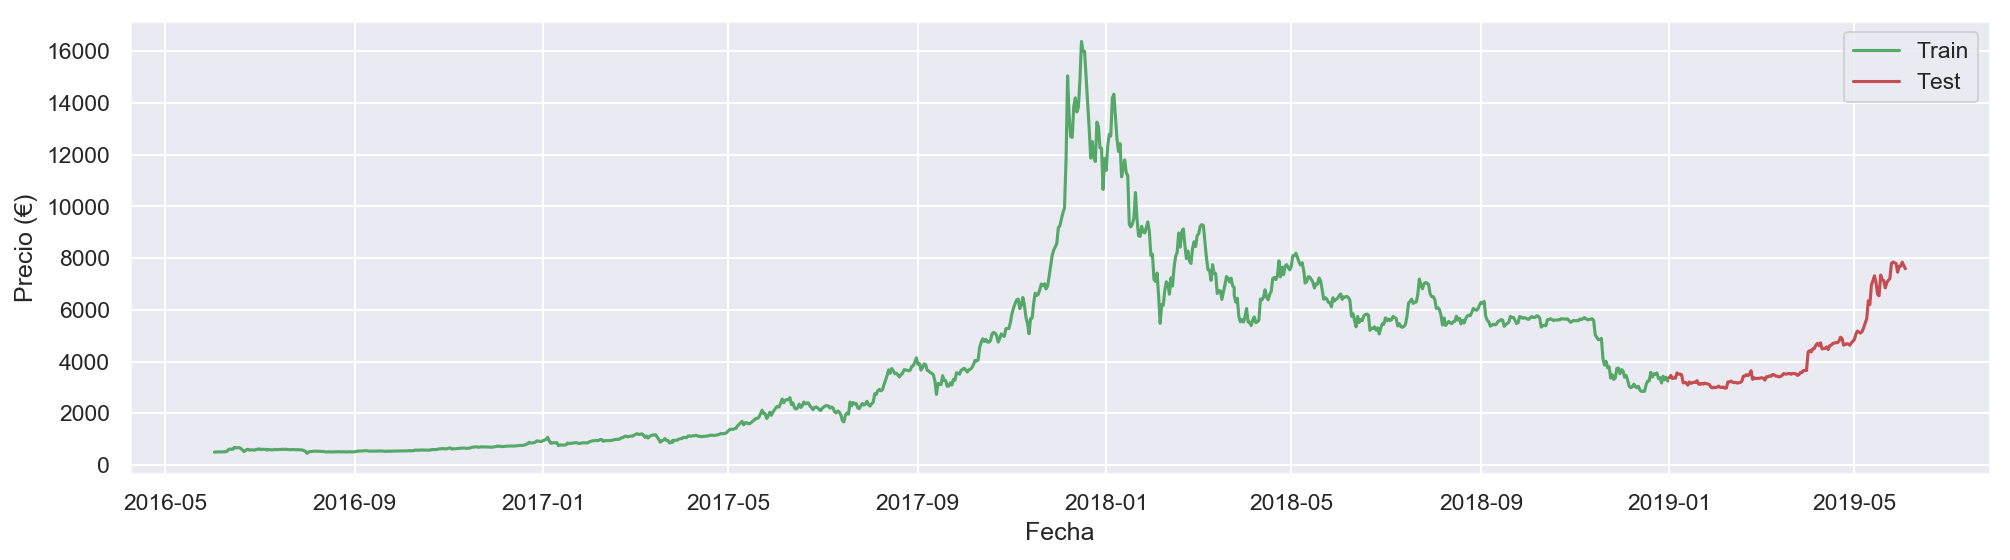

In [9]:
plt.figure(figsize=(16, 4))
plt.plot(BTC_train_serie, color='g')
plt.plot(BTC_test_serie, color='r')
plt.legend(['Train', 'Test'])
plt.xlabel('Fecha')
plt.ylabel('Precio (€)')
plt.show()

## Transformación log10

La transformación logarítimica de la serie reduce la varianza de los datos permitiendo un modelado más preciso.

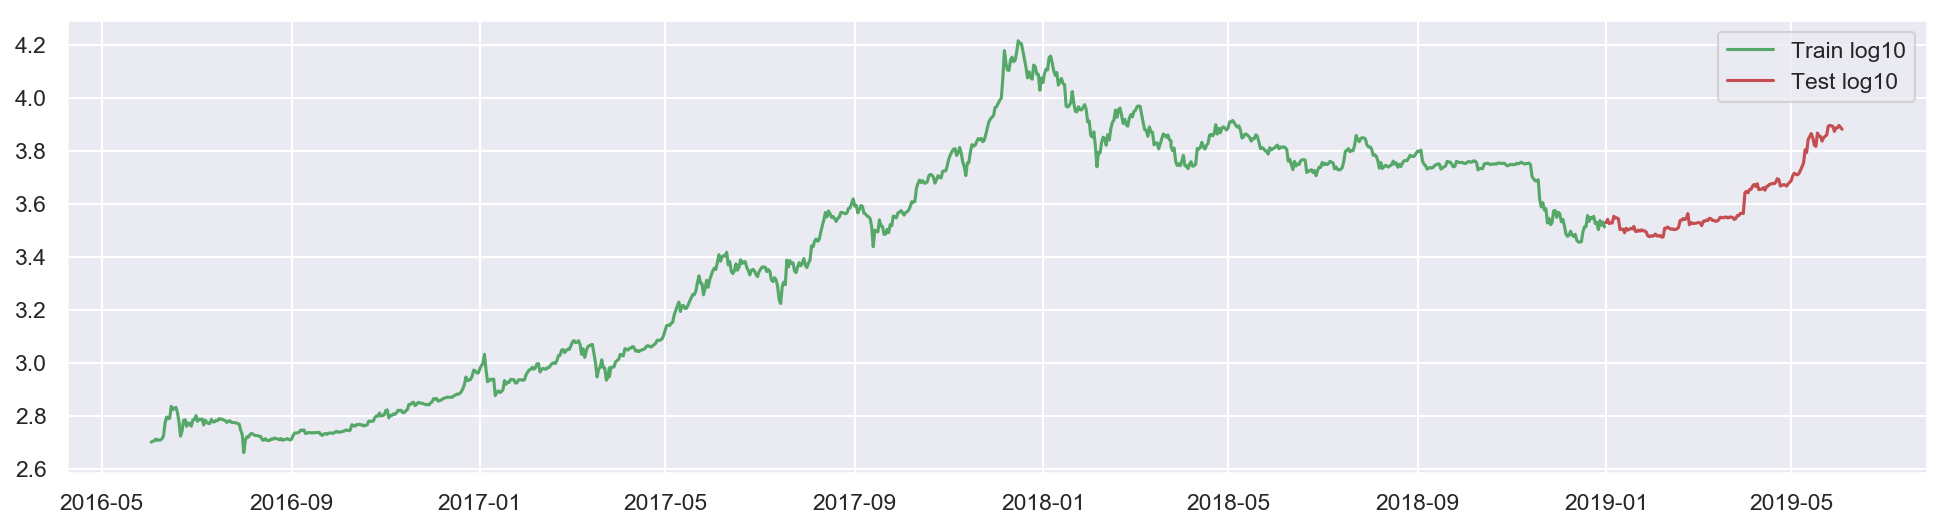

In [149]:
plt.figure(figsize=(16, 4))

BTC_train_log10 = np.log10(BTC_train_serie)
BTC_test_log10  = np.log10(BTC_test_serie)
plt.plot(BTC_train_log10, color='g')
plt.plot(BTC_test_log10, color='r')
plt.legend(['Train log10', 'Test log10'])

plt.show();

## Tendencia
Para modelar la tendencia se buscarán representaciones simples de la serie temporal mediante filtros de suavizado. Estos filtros deben describir la tendencia general de la serie y no detalles locales, dado que esto puede resultar en una eliminación de frecuencias importantes.
### Filtros de suavizado

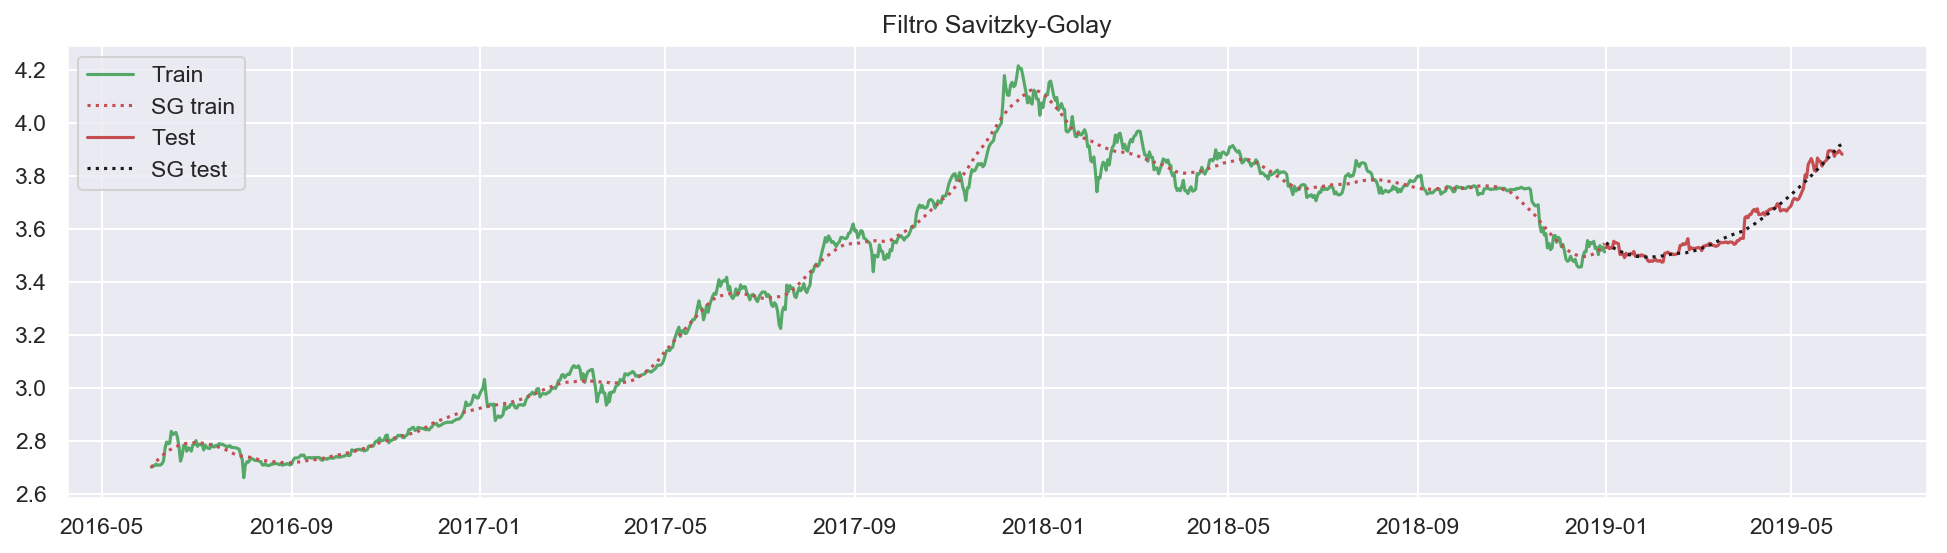

In [150]:
# Savitzky-Golay
from scipy.signal import savgol_filter

w_length = 91
order = 3

BTC_train_SG_filter = savgol_filter(BTC_train_log10.values.flatten(), window_length=w_length, polyorder=order)
BTC_test_SG_filter = savgol_filter(BTC_test_log10.values.flatten(), window_length=w_length, polyorder=order)

plt.figure(figsize=(16, 4))
plt.plot(BTC_train_index, BTC_train_log10, color='g')
plt.plot(BTC_train_index, BTC_train_SG_filter, linestyle=':', color='r')
plt.plot(BTC_test_index, BTC_test_log10, color='r')
plt.plot(BTC_test_index, BTC_test_SG_filter, linestyle=':', color='k')
plt.title('Filtro Savitzky-Golay')

plt.legend(['Train', 'SG train', 'Test', 'SG test'])

plt.show();

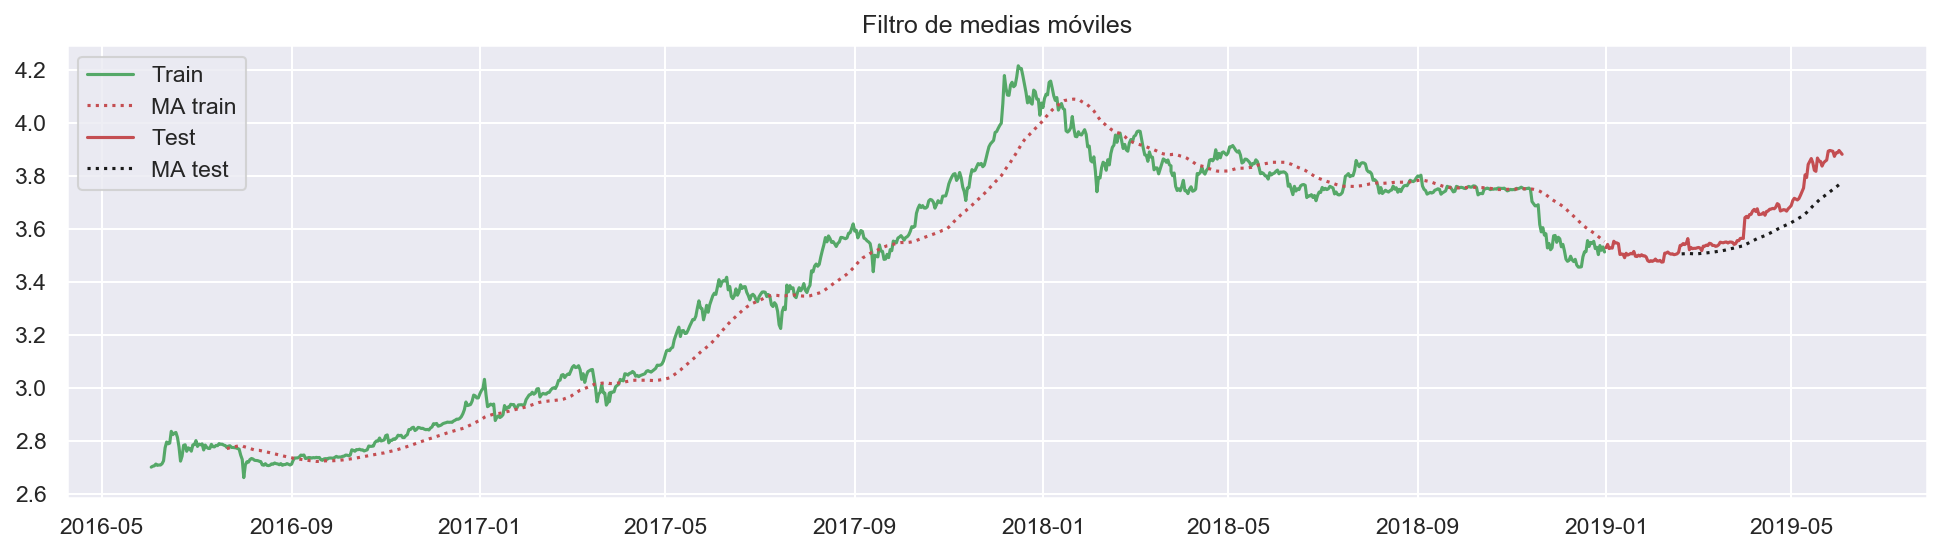

In [151]:
## Medias móviles
window_size_ma = 50
BTC_train_MA_filter = BTC_train_log10[['Adj Close']].rolling(window=window_size_ma).mean()
BTC_test_MA_filter = BTC_test_log10[['Adj Close']].rolling(window=window_size_ma).mean()

plt.figure(figsize=(16, 4))
plt.plot(BTC_train_index, BTC_train_log10, color='g')
plt.plot(BTC_train_index, BTC_train_MA_filter, linestyle=':', color='r')
plt.plot(BTC_test_index, BTC_test_log10, color='r')
plt.plot(BTC_test_index, BTC_test_MA_filter, linestyle=':', color='k')
plt.title('Filtro de medias móviles')

plt.legend(['Train', 'MA train', 'Test', 'MA test'])
plt.show();

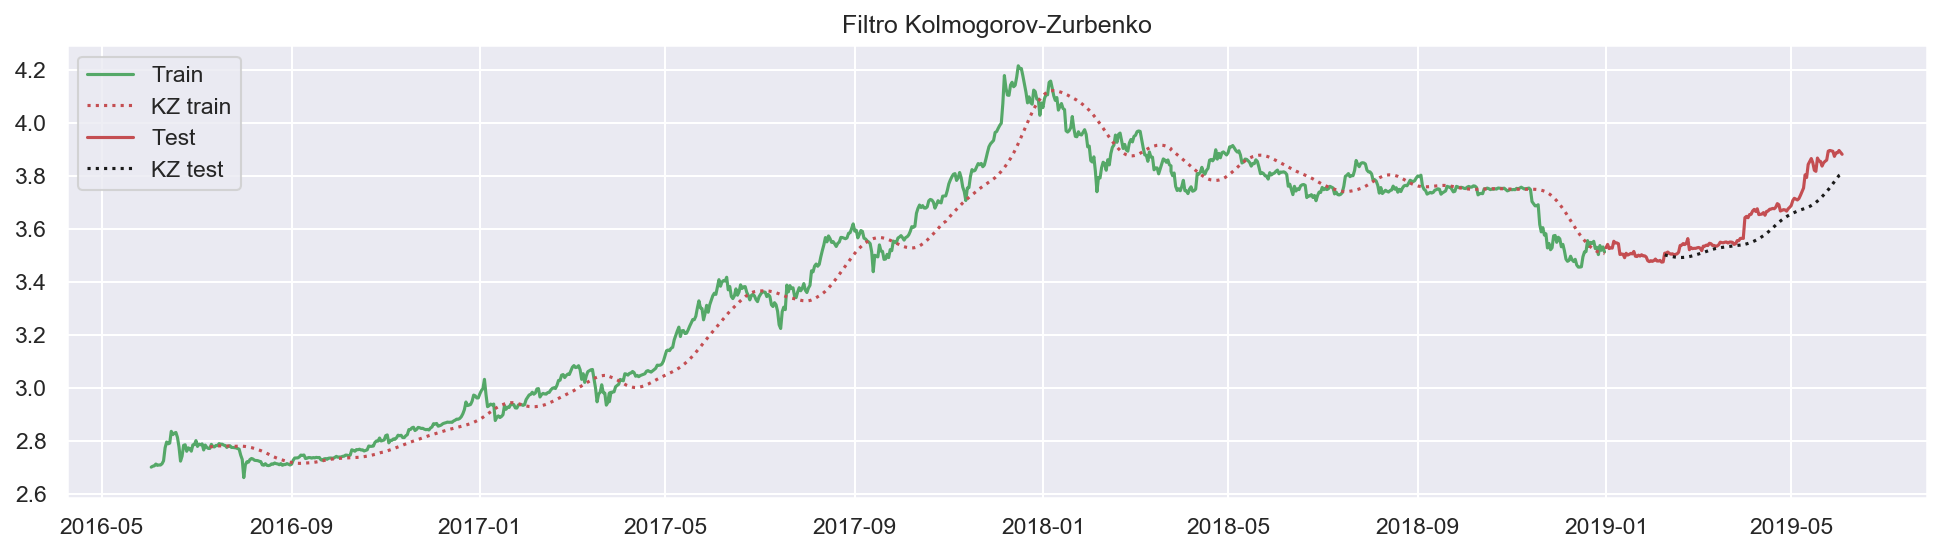

In [152]:
## Kolmogorov-Zurbenko
window_size_kz = 20
degree_kz = 2

BTC_train_KZ_filter = kz_filter(BTC_train_log10[['Adj Close']].values.flatten(), window_size_kz, degree_kz)
BTC_test_KZ_filter = kz_filter(BTC_test_log10[['Adj Close']].values.flatten(), window_size_kz, degree_kz)

plt.figure(figsize=(16, 4))
plt.plot(BTC_train_index, BTC_train_log10, color='g')
plt.plot(BTC_train_index[(len(BTC_train_log10)-len(BTC_train_KZ_filter)):], BTC_train_KZ_filter, linestyle=':', color='r')
plt.plot(BTC_test_index, BTC_test_log10, color='r')
plt.plot(BTC_test_index[(len(BTC_test_log10)-len(BTC_test_KZ_filter)):], BTC_test_KZ_filter, linestyle=':', color='k')
plt.title('Filtro Kolmogorov-Zurbenko')

plt.legend(['Train', 'KZ train', 'Test', 'KZ test'])

plt.show();

Los filtros Kolmogorov-Zurbenko y de medias moviles producen un desfase en el ajuste de la tendencia, algo que puede resultar problemático a la hora de modelar el comportamiento de la serie. Además, en ambos se produce una pérdida de datos dado que necesitan de un conjunto incial de datos para comenzar el suavizado.

En este sentido, el filtro Savitzky-Golay es el que mejor resultado ofrece produciendo una serie suavizada y ajustada temporalmente con la original. Además consigue reflejar tendencias generales en determinados periodos temporales, que es lo que se busca con este proceso.

## Interpolación cuadrática

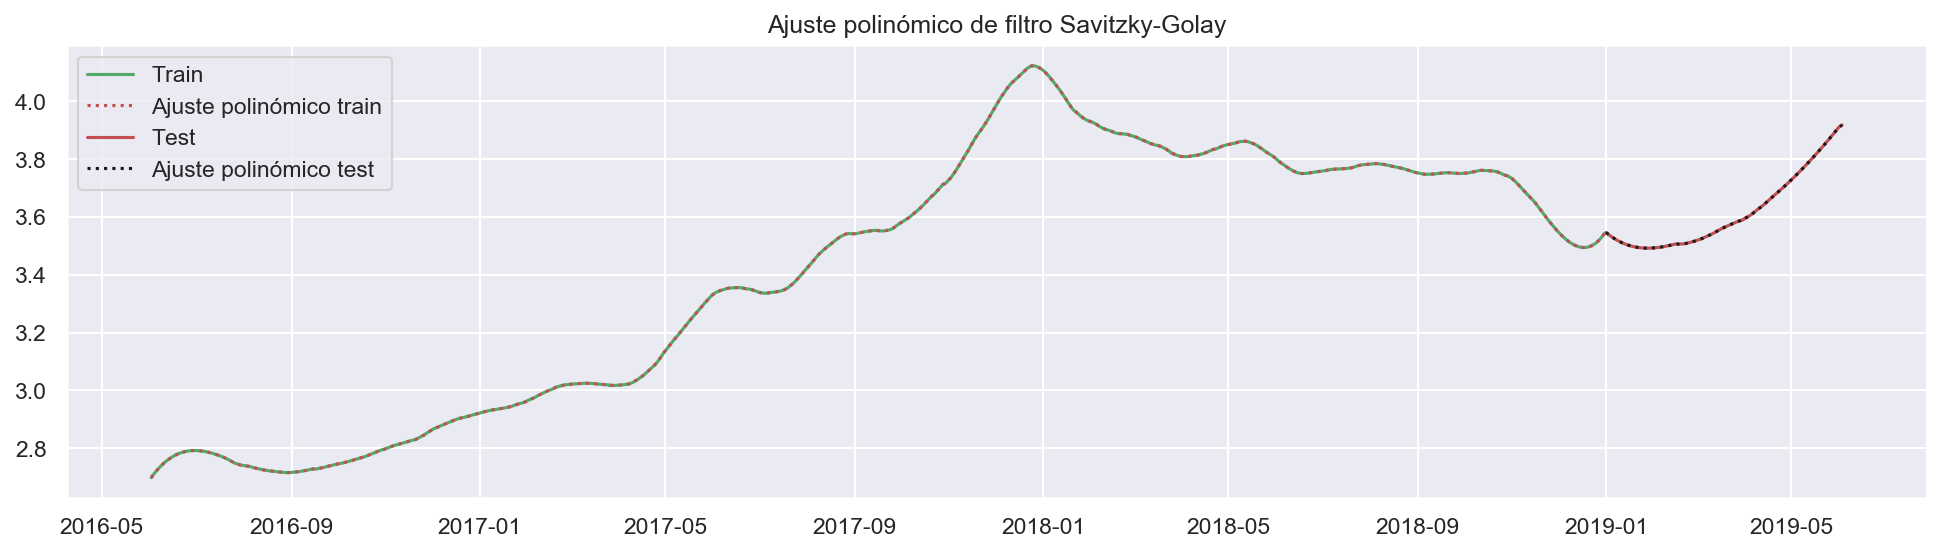

In [153]:
from matplotlib.dates import date2num
from scipy import interpolate


BTC_train_interpolation = interpolate.interp1d(range(len(BTC_train_SG_filter)), BTC_train_SG_filter, kind='quadratic')
train_interp_values = test_interp_values = BTC_train_interpolation(range(len(BTC_train_SG_filter)))
BTC_test_interpolation = interpolate.interp1d(range(len(BTC_test_SG_filter)), BTC_test_SG_filter, kind='quadratic')
test_interp_values = BTC_test_interpolation(range(len(BTC_test_SG_filter)))


plt.figure(figsize=(16, 4))
plt.plot(BTC_train_index, BTC_train_SG_filter, color='g')
plt.plot(BTC_train_index, train_interp_values, linestyle=':', color='r')
plt.plot(BTC_test_index, BTC_test_SG_filter, color='r')
plt.plot(BTC_test_index, test_interp_values, linestyle=':', color='k')
plt.title('Ajuste polinómico de filtro Savitzky-Golay')
plt.legend(['Train', 'Ajuste polinómico train', 'Test', 'Ajuste polinómico test'])


## Eliminar tendencia
Para eliminar la tenencia, se resta el ajuste polinómico realizado a la serie original

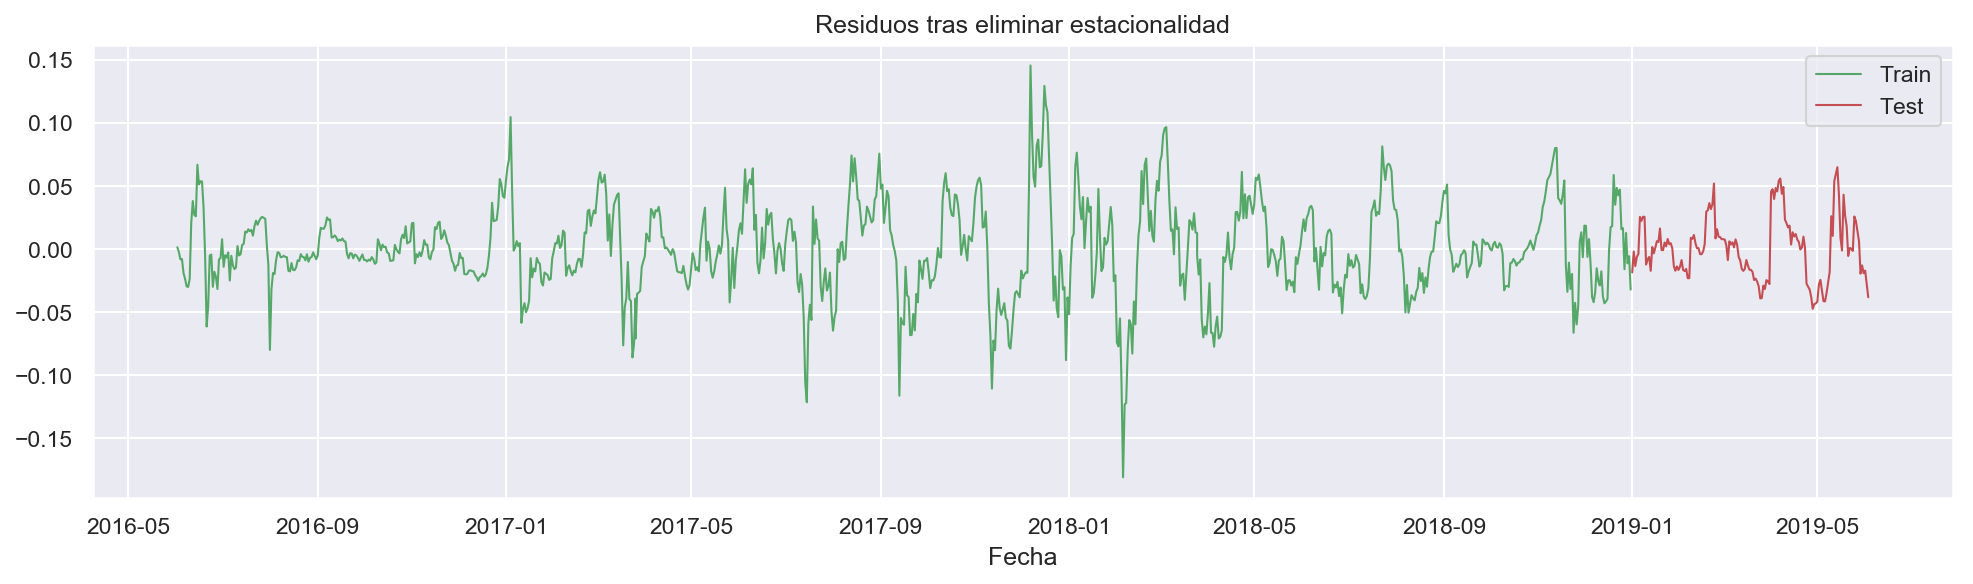

In [154]:
BTC_train_notend = BTC_train_log10.values.flatten() - train_interp_values
BTC_test_notend  = BTC_test_log10.values.flatten() - test_interp_values

plt.figure(figsize=(16, 4))
plt.plot(BTC_train_index, BTC_train_notend, color='g', linewidth=1)
plt.plot(BTC_test_index,  BTC_test_notend, color='r', linewidth=1)
plt.title('Residuos tras eliminar estacionalidad')

plt.xlabel('Fecha')
plt.legend(['Train', 'Test'])

plt.show()

## Normalidad de residuos
Los residuos generados han de seguir una distribución normal.
### Test Shapiro-Wilk y Jarque-Bera

In [260]:
# Normality
from scipy.stats import shapiro, jarque_bera

# Shapiro-Wilk test (H0 = Normal distribution)
p_value_sw, stat = shapiro(BTC_train_notend)
print(p_value_sw)

# Jarque-Bera to test skewness and kurtosis
stat_jb, p_value_jb = jarque_bera(BTC_train_notend)
print(p_value_jb)


0.9829408526420593
0.0


### Histograma

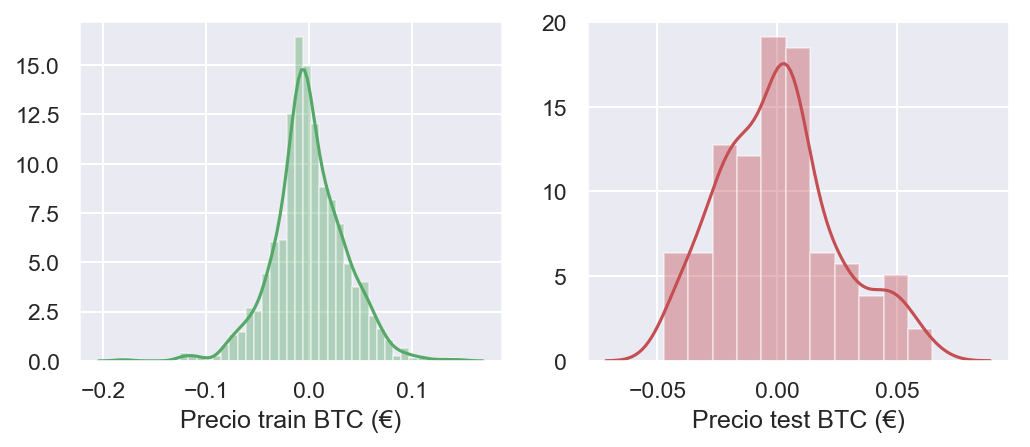

In [262]:
plt.figure(figsize=(8, 3))
plt.subplot(1, 2, 1)
sns.distplot(BTC_train_notend, axlabel='Precio train BTC (€)', color='g');
plt.subplot(1, 2, 2)
sns.distplot(BTC_test_notend, axlabel='Precio test BTC (€)', color='r');
plt.show()

### QQ-Plot

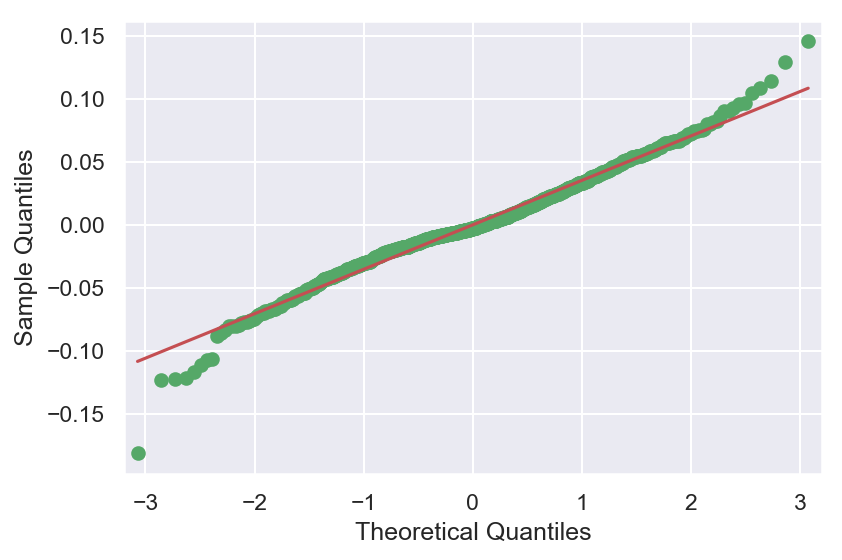

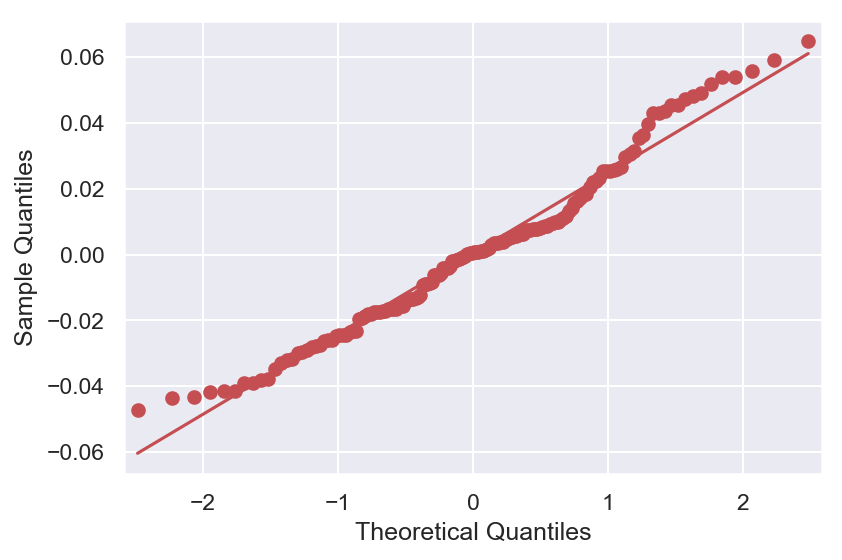

In [157]:
qqplot(BTC_train_notend, line='s', color='g');
qqplot(BTC_test_notend, line='s', color='r');


## Estacionaridad
La metodología Box-Jenkins aplicada requiere que la serie a modelar sea estacionaria, es decir, que su media y su varianza sean independientes del tiempo.

A continuación, se comprobará esta condiciendo mediante el test de Dickey-Fuller ampliado.


In [158]:
# Dickey-Fuller Test - BTC with no trend
# H0: Time serie has unit root, non-stationary
# H1: Time serie has not unit root, stationary

stat_df_train, p_value_ad_train, _, _, conf_levels_train, _ = adfuller(BTC_train_notend)
stat_df_test, p_value_ad_test, _, _, conf_levels_test, _ = adfuller(BTC_test_notend)
print(p_value_ad_train)
print(p_value_ad_test)

5.899619703243707e-15
0.01024156569825136


La serie de entrenamiento pasa la prueba, pero no la de test. Existen componentes estacionales en la serie.

## Estacionalidad

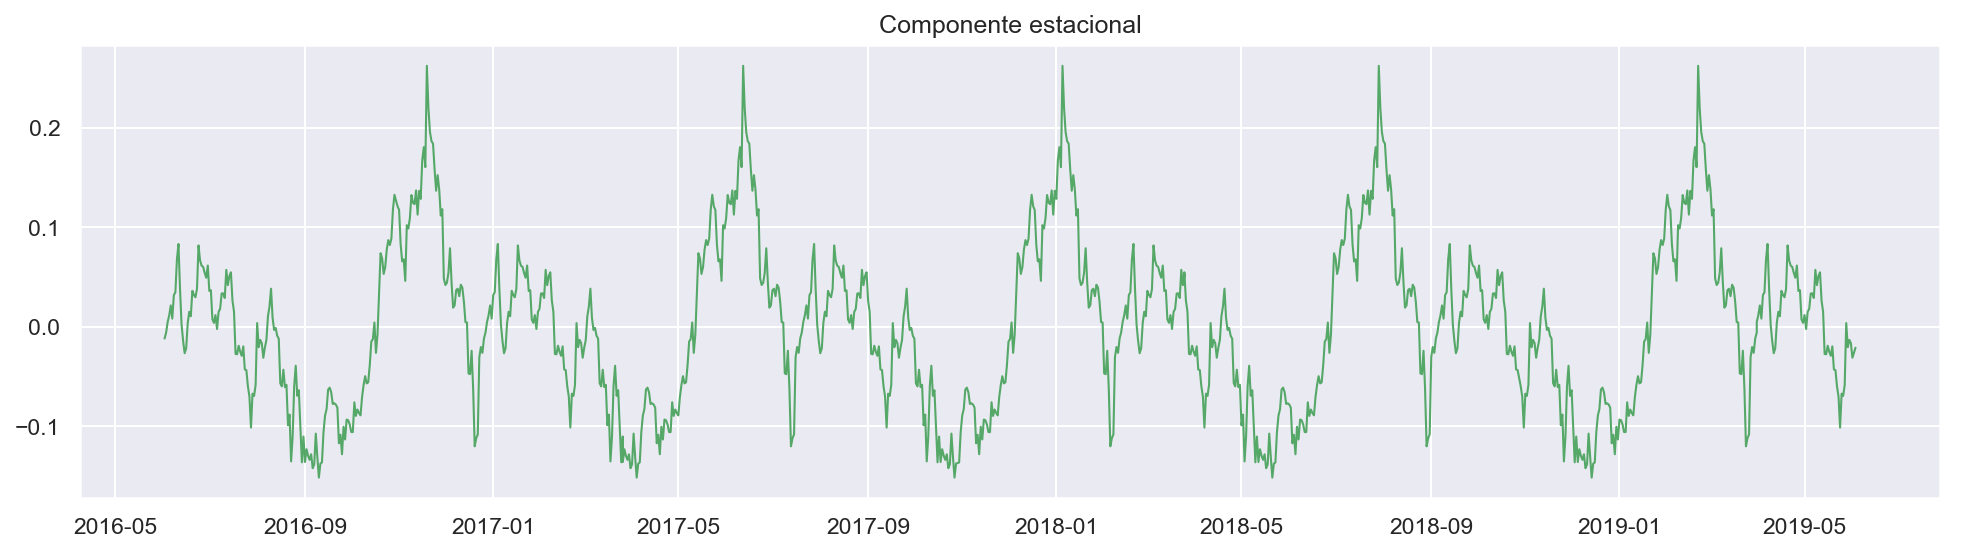

In [159]:
## Estacionalidad - 206 días
BTC_log = np.log(BTC_serie)

BTC_decompose = seasonal_decompose(BTC_log, model='aditive', freq=206)
BTC_seasonality = BTC_decompose.seasonal
plt.figure(figsize=(16, 4))
plt.title('Componente estacional')
plt.plot(BTC_seasonality, color='g', linewidth=1)
plt.show()

In [160]:
## Eliminar estacionalidad
train_stacionality = BTC_seasonality[:len(BTC_train_notend)].values
test_stacionality  = BTC_seasonality[len(BTC_train_notend):].values
BTC_train_notend_nosta = BTC_train_notend - train_stacionality.flatten()
BTC_test_notend_nosta  = BTC_test_notend - test_stacionality.flatten()

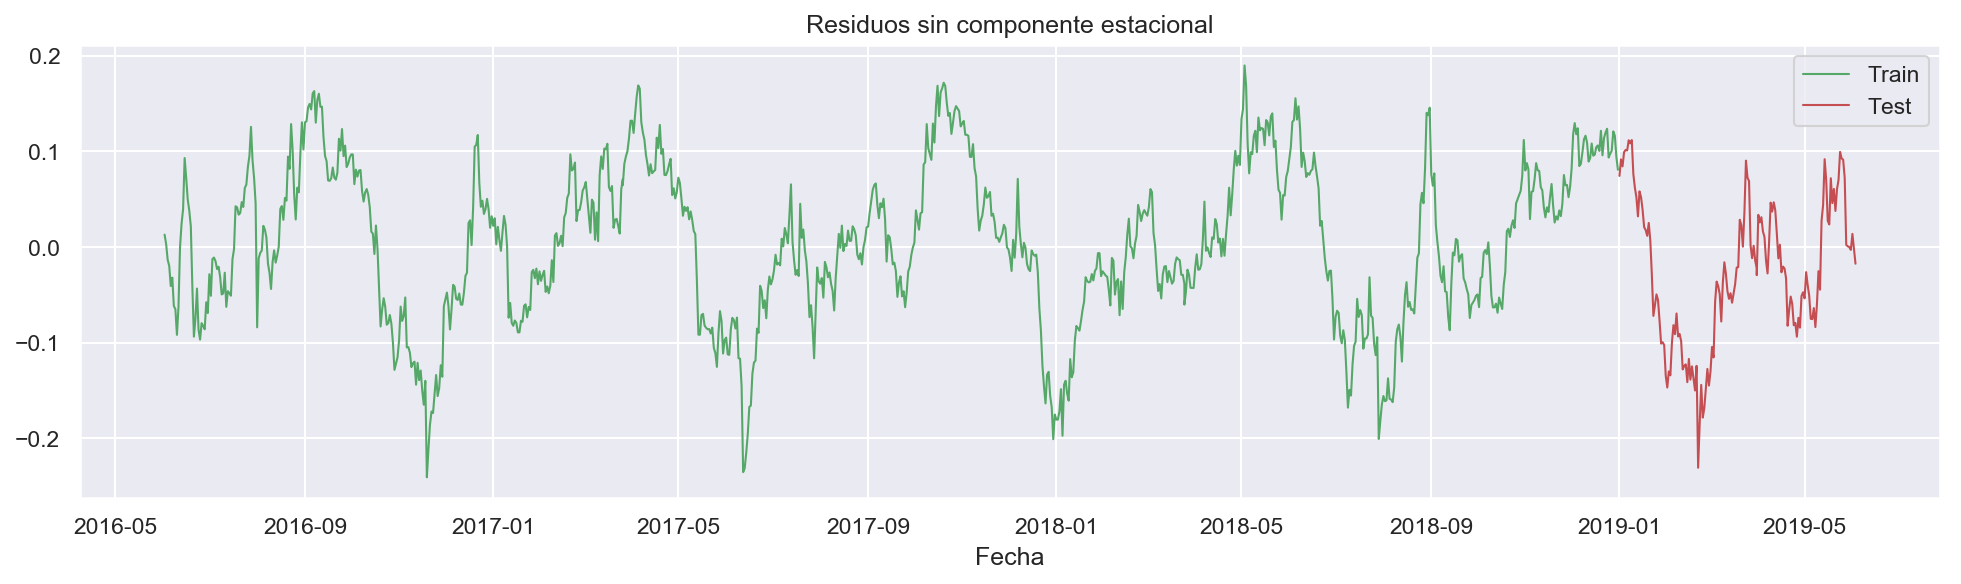

In [161]:
## Representación
plt.figure(figsize=(16, 4))
plt.plot(BTC_train_index, BTC_train_notend_nosta, color='g', linewidth=1)
plt.plot(BTC_test_index,  BTC_test_notend_nosta, color='r', linewidth=1)
plt.title('Residuos sin componente estacional')

plt.xlabel('Fecha')
plt.legend(['Train', 'Test'])

plt.show()

## Estacionaridad

In [162]:
# Dickey-Fuller Test
# H0: Time serie has unit root, non-stationary
# H1: Time serie has not unit root, stationary

stat_df_train, p_value_ad_train, _, _, conf_levels_train, _ = adfuller(BTC_train_notend_nosta)
stat_df_test, p_value_ad_test, _, _, conf_levels_test, _ = adfuller(BTC_test_notend_nosta)
print(p_value_ad_train)
print(p_value_ad_test)

0.001658211953489825
0.16113537477048995


El conjunto de test sigue sin ser estacionario tras eliminar la componente frecuencial de 206 días, por lo que será necesario diferencias la serie para conseguir esta condición.

## Diferenciación

In [163]:
## Order 1 differencing
BTC_train_notend_nosta_diff = np.diff(BTC_train_notend_nosta)
BTC_test_notend_nosta_diff = np.diff(BTC_test_notend_nosta)

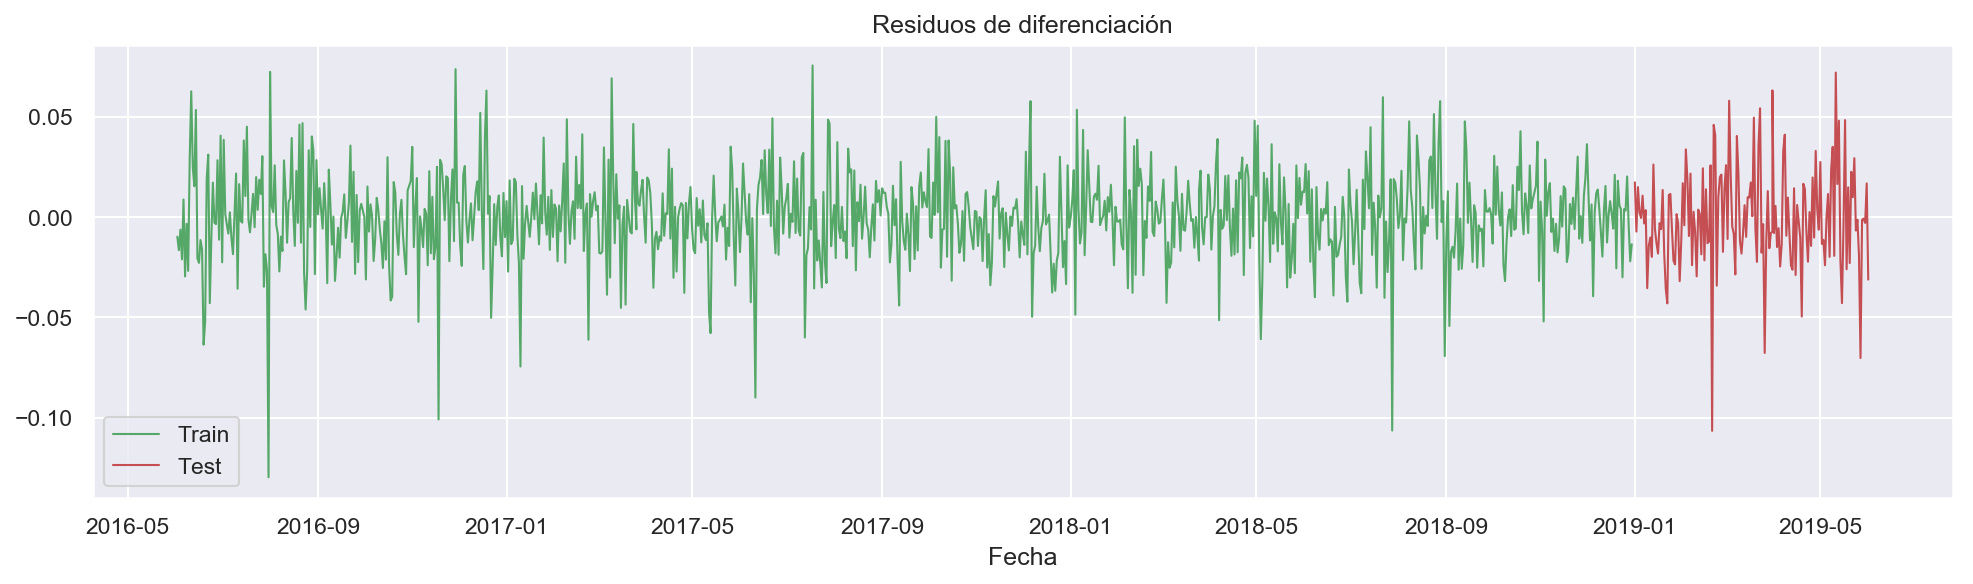

In [164]:
# Plot
plt.figure(figsize=(16, 4))
plt.plot(BTC_train_index[:-1], BTC_train_notend_nosta_diff, color='g', linewidth=1)
plt.plot(BTC_test_index[:-1],  BTC_test_notend_nosta_diff, color='r', linewidth=1)
plt.title('Residuos de diferenciación')
plt.xlabel('Fecha')
plt.legend(['Train', 'Test'])

plt.show()

In [165]:
# Dickey-Fuller Test
# H0: Time serie has unit root, non-stationary
# H1: Time serie has not unit root, stationary

stat_df_train, p_value_ad_train, _, _, conf_levels_train, _ = adfuller(BTC_train_notend_nosta_diff)
stat_df_test, p_value_ad_test, _, _, conf_levels_test, _ = adfuller(BTC_test_notend_nosta_diff)
print(p_value_ad_train)
print(p_value_ad_test)

2.6519972560675734e-29
8.926152509963621e-25


La diferenciación de la serie consigue una componente residual estacionaria.

## Normalidad de residuos

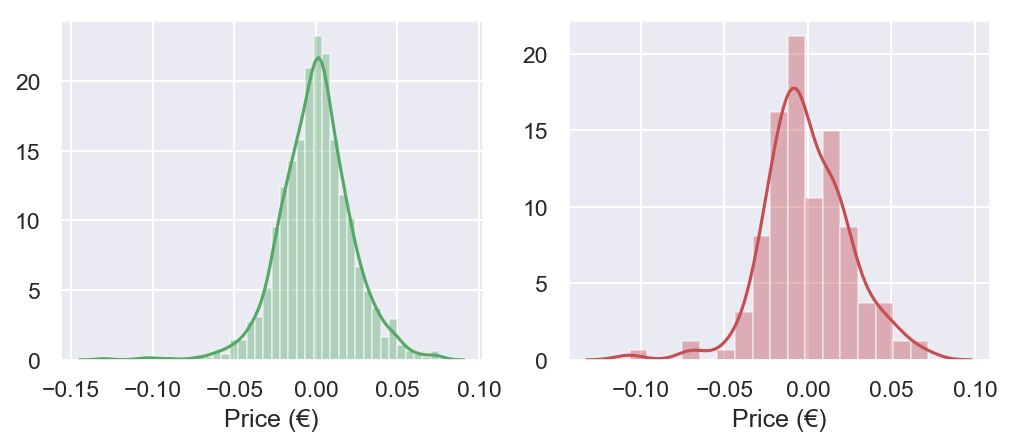

In [166]:
plt.figure(figsize=(8, 3))
plt.subplot(1, 2, 1)
sns.distplot(BTC_train_notend_nosta_diff, axlabel='Price (€)', color='g');
plt.subplot(1, 2, 2)
sns.distplot(BTC_test_notend_nosta_diff, axlabel='Price (€)', color='r');
plt.show()

In [167]:
# Shapiro-Wilk test (H0 = Normal distribution)
p_value_sw_train, stat = shapiro(BTC_train_notend_nosta_diff)
p_value_sw_test, stat = shapiro(BTC_test_notend_nosta_diff)
print(p_value_sw_train)
print(p_value_sw_test)

# Jarque-Bera to test skewness and kurtosis
stat_jb, p_value_jb_train = jarque_bera(BTC_train_notend_nosta_diff)
stat_jb, p_value_jb_test = jarque_bera(BTC_test_notend_nosta_diff)
print(p_value_jb_train)
print(p_value_jb_test)

0.974368155002594
0.9700444936752319
0.0
1.0324695689845065e-05


## Modelado

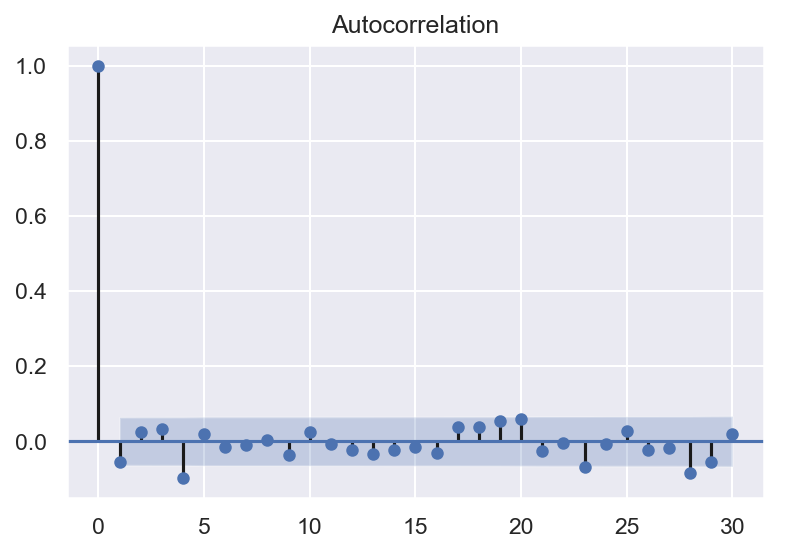

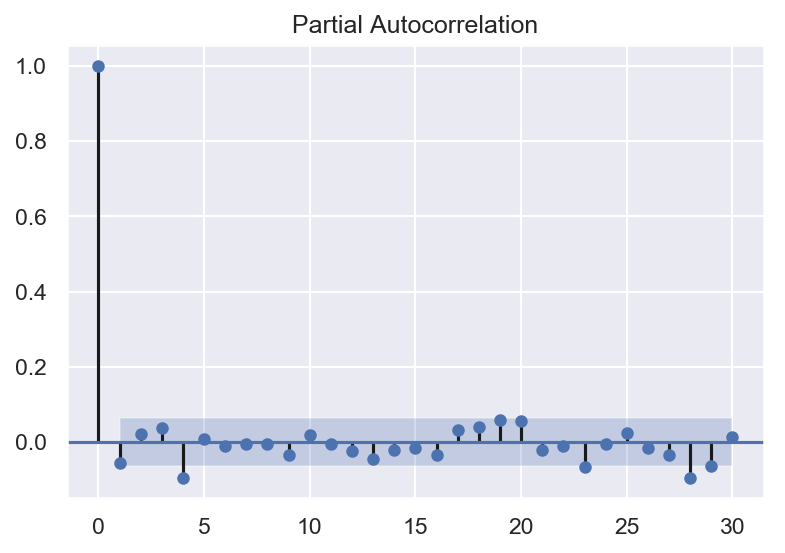

In [168]:
## ACF and PACF plots - BTC
plot_acf(BTC_train_notend_nosta_diff, lags=30)
plot_pacf(BTC_train_notend_nosta_diff, lags=30)
plt.show()

Atendiendo a los gráficos PACF y ACF, se propone el uso de un modelo ARIMA de orden (2, 1, 0)

In [223]:
# ARIMA model
arima_order = (4, 1, 0)
arima_model = ARIMA(BTC_train_notend_nosta, order=arima_order)
arima_model_fitted = arima_model.fit(disp=0)
print(arima_model_fitted.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  941
Model:                 ARIMA(4, 1, 0)   Log Likelihood                2254.046
Method:                       css-mle   S.D. of innovations              0.022
Date:                Sun, 09 Jun 2019   AIC                          -4496.092
Time:                        17:16:48   BIC                          -4467.010
Sample:                             1   HQIC                         -4485.007
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       7.639e-05      0.001      0.116      0.908      -0.001       0.001
ar.L1.D.y     -0.0507      0.032     -1.563      0.118      -0.114       0.013
ar.L2.D.y      0.0249      0.032      0.768      0.4

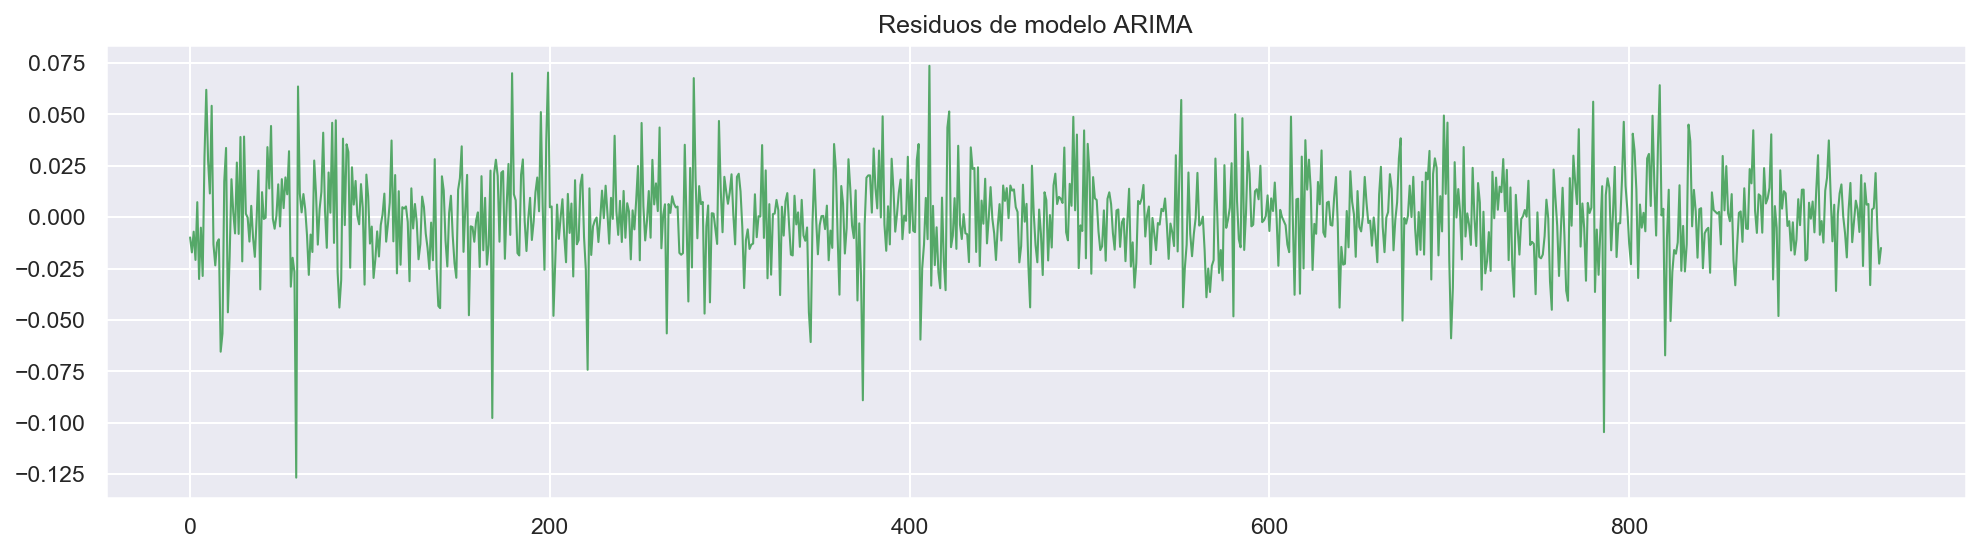

0.9762547016143799


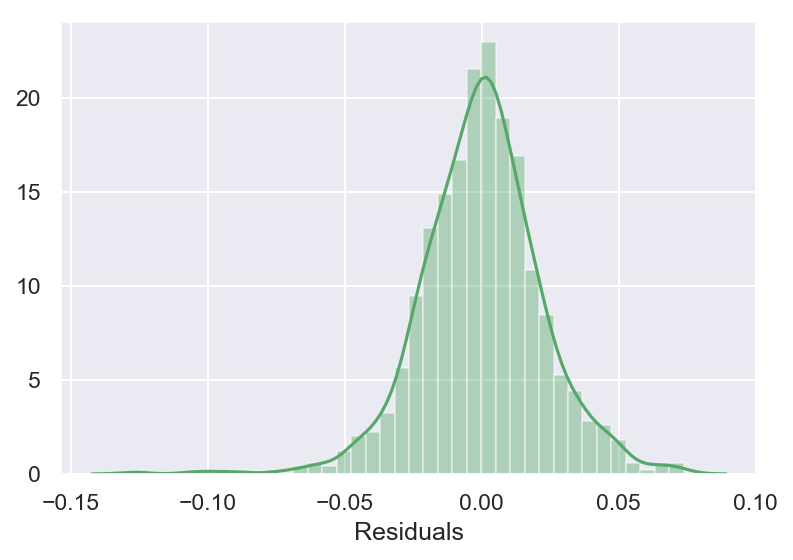

In [224]:
# Get residuals and evaluate normality
arima_res = arima_model_fitted.resid

plt.figure(figsize=(16, 4))
plt.plot(arima_res, color='g', linewidth=1)
plt.title('Residuos de modelo ARIMA')
plt.show()

sns.distplot(arima_res, axlabel='Residuals', color='g');
p_value_sw_res, stat = shapiro(arima_res)
print(p_value_sw_res)


In [225]:
# Errors
# MSE
mse_train = mean_squared_error(BTC_train_notend_nosta_diff, arima_res)

# MAE
mae_train = mean_absolute_error(BTC_train_notend_nosta_diff, arima_res)

print(mse_train)
print(mae_train)

6.6441093515332735e-06
0.0019263777273545728


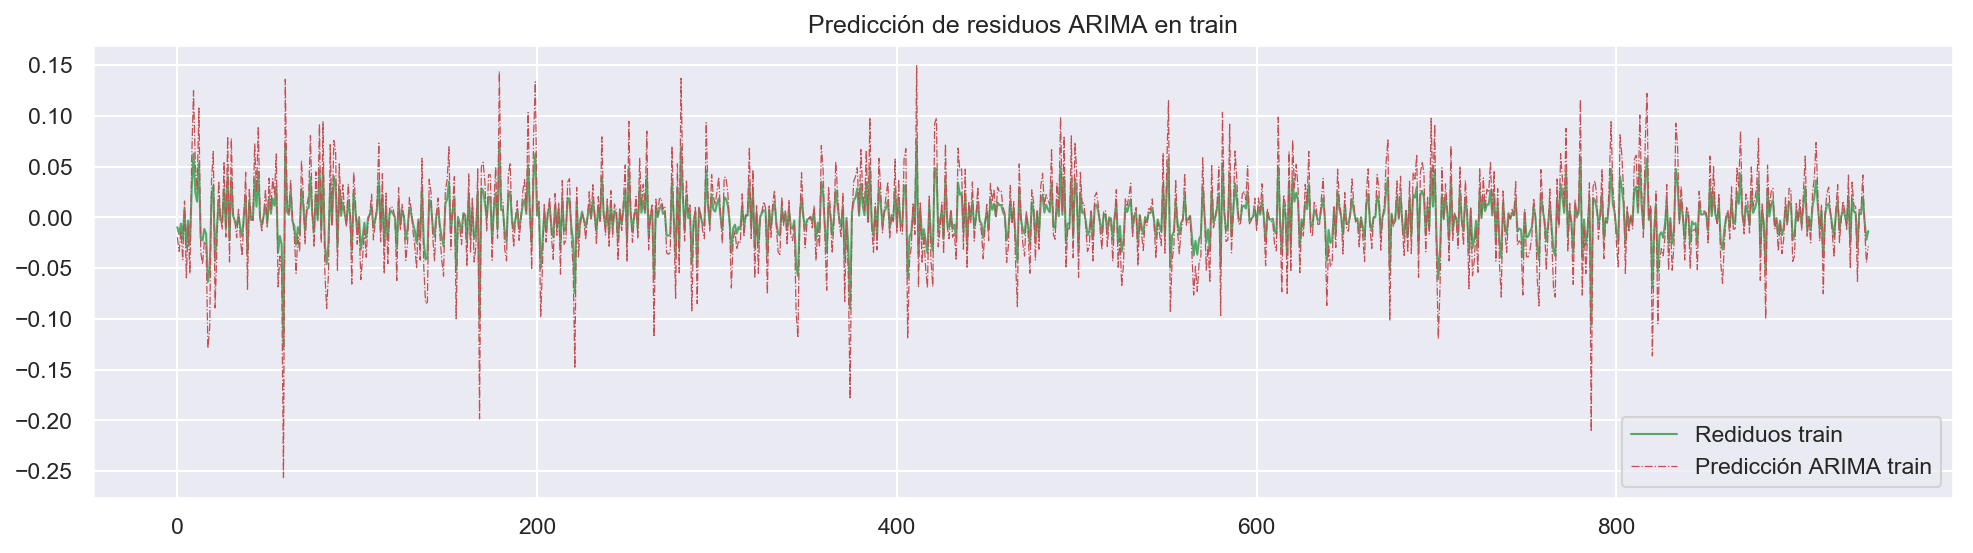

In [226]:
## Residual train adjustment
BTC_train_adjust = BTC_train_notend_nosta_diff + arima_res

plt.figure(figsize=(16, 4))
plt.plot(BTC_train_notend_nosta_diff, color='g', linewidth=1)
plt.plot(BTC_train_adjust, color='r', linewidth=0.6, linestyle='-.')
plt.legend(['Rediduos train', 'Predicción ARIMA train'])
plt.title('Predicción de residuos ARIMA en train')
plt.show()


## Plot

In [227]:
## Prediction function
## Once a value is forescasted, it is included in model creation data.
def forecast_arima(train, test, arima_order):
    predictions = np.array([])
    model_data = train
    
    for tst_value in test:
        # Create model
        arima_model = ARIMA(model_data, order=arima_order)
        fitted_model = arima_model.fit(disp=0)
        
        # Forecast next value
        predictions = np.append(predictions, fitted_model.forecast(steps=1)[0])
        
        # Add predicted value to model_data set
        model_data = np.append(model_data, tst_value)
    
    return predictions

In [228]:
# Run test predictions
#test_predictions = forecast_arima(BTC_train_notend_nosta, BTC_test_notend_nosta, arima_order)
arima_test = ARIMA(BTC_train_notend_nosta, order=arima_order)
arima_test = arima_test.fit(disp=0)
arima_test_predictions = arima_test.forecast(len(BTC_test_notend_nosta))

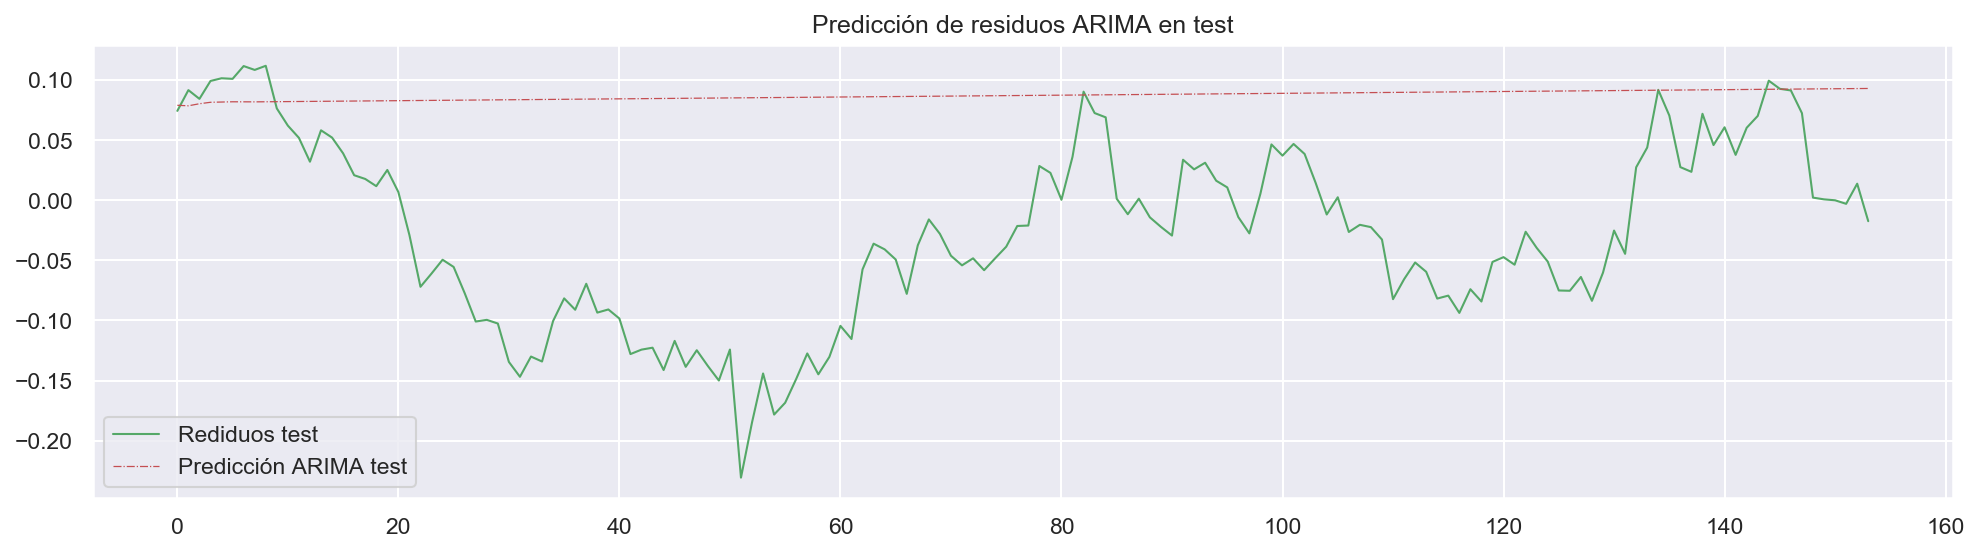

In [229]:
# Plot real and predicted test on residuals
plt.figure(figsize=(16, 4))
plt.plot(BTC_test_notend_nosta, color='g', linewidth=1)
plt.plot(arima_test_predictions[0], color='r', linewidth=0.6, linestyle='-.')
plt.legend(['Rediduos test', 'Predicción ARIMA test'])
plt.title('Predicción de residuos ARIMA en test')
plt.show()

In [230]:
## Include transformations on train residual predictions
restaured_train_residual_predictions = BTC_train_adjust + train_stacionality.flatten()[:-1] + train_interp_values[:-1]

## Include transformations on test residual predictions
restaured_test_residual_predictions = arima_test_predictions[0] + test_stacionality.flatten() + test_interp_values

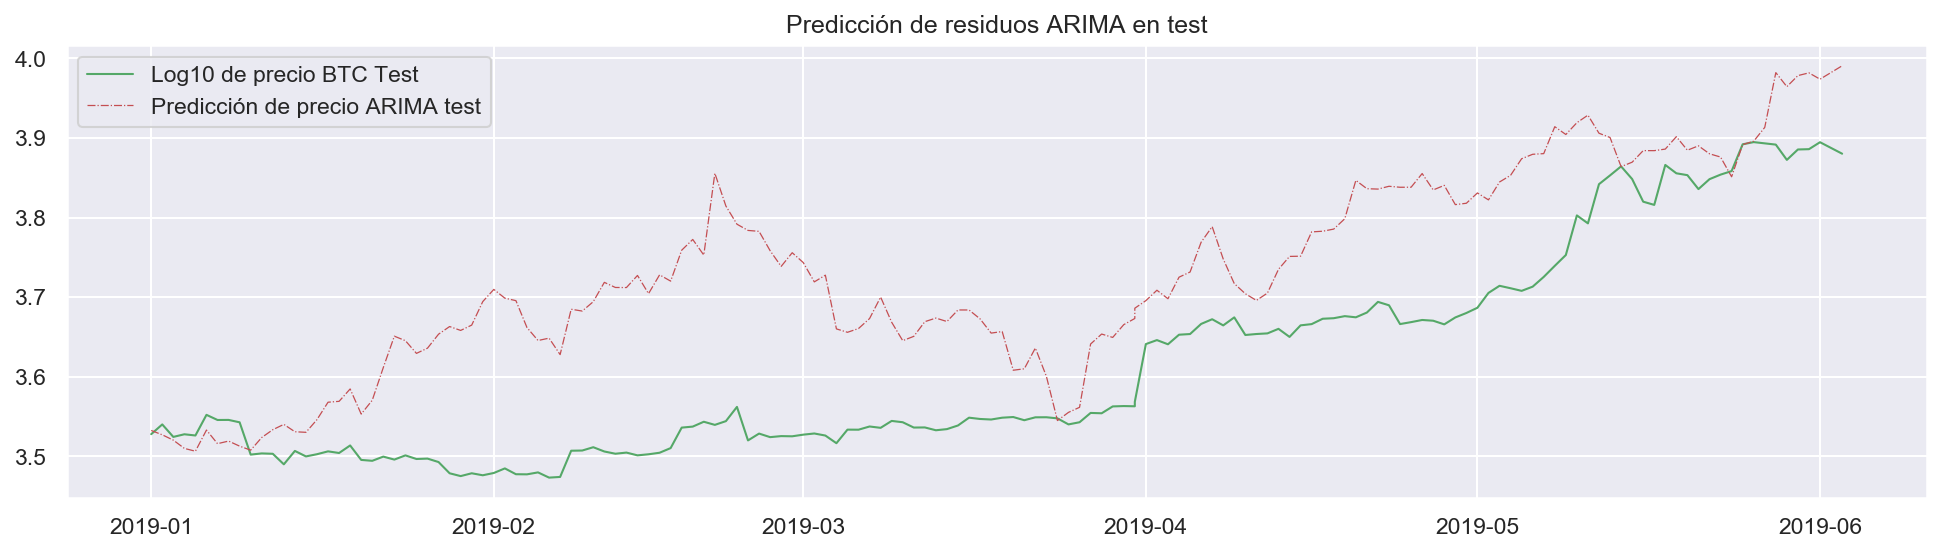

In [231]:
plt.figure(figsize=(16, 4))
plt.plot(BTC_test_index, BTC_test_log10, color='g', linewidth=1)
plt.plot(BTC_test_index, restaured_test_residual_predictions, color='r', linewidth=0.6, linestyle='-.')
plt.legend(['Log10 de precio BTC Test', 'Predicción de precio ARIMA test'])
plt.title('Predicción de residuos ARIMA en test')
plt.show()

La predicción sobre los datos de test, aunque no exacta, consigue reflejar a la perfección la subida del precio experimentada a partir de 2019. Así, además de conseguir plasmar la tendencia ascendente, en algunos puntos consigue predecir óptimos locales e identificar pequeñas subidas y bajadas.

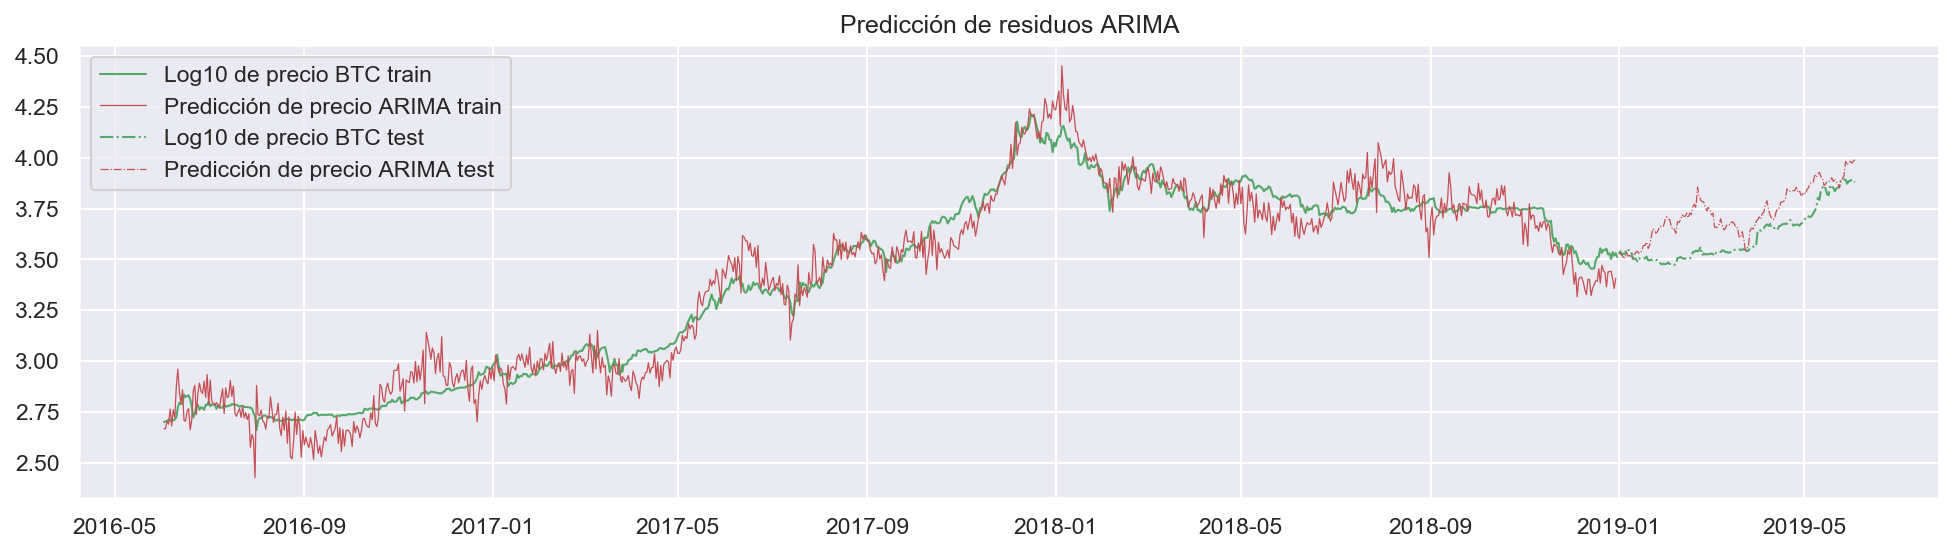

In [232]:
# Plot of predicted values
plt.figure(figsize=(16, 4))
plt.plot(BTC_train_index, BTC_train_log10, color='g', linewidth=1)
plt.plot(BTC_train_index[:-1], restaured_train_residual_predictions, color='r', linewidth=0.6, linestyle='-')
plt.plot(BTC_test_index, BTC_test_log10, color='g', linewidth=1, linestyle='-.')
plt.plot(BTC_test_index, restaured_test_residual_predictions, color='r', linewidth=0.6, linestyle='-.')
plt.legend(['Log10 de precio BTC train', 'Predicción de precio ARIMA train', 'Log10 de precio BTC test','Predicción de precio ARIMA test'])
plt.title('Predicción de residuos ARIMA')
plt.show()

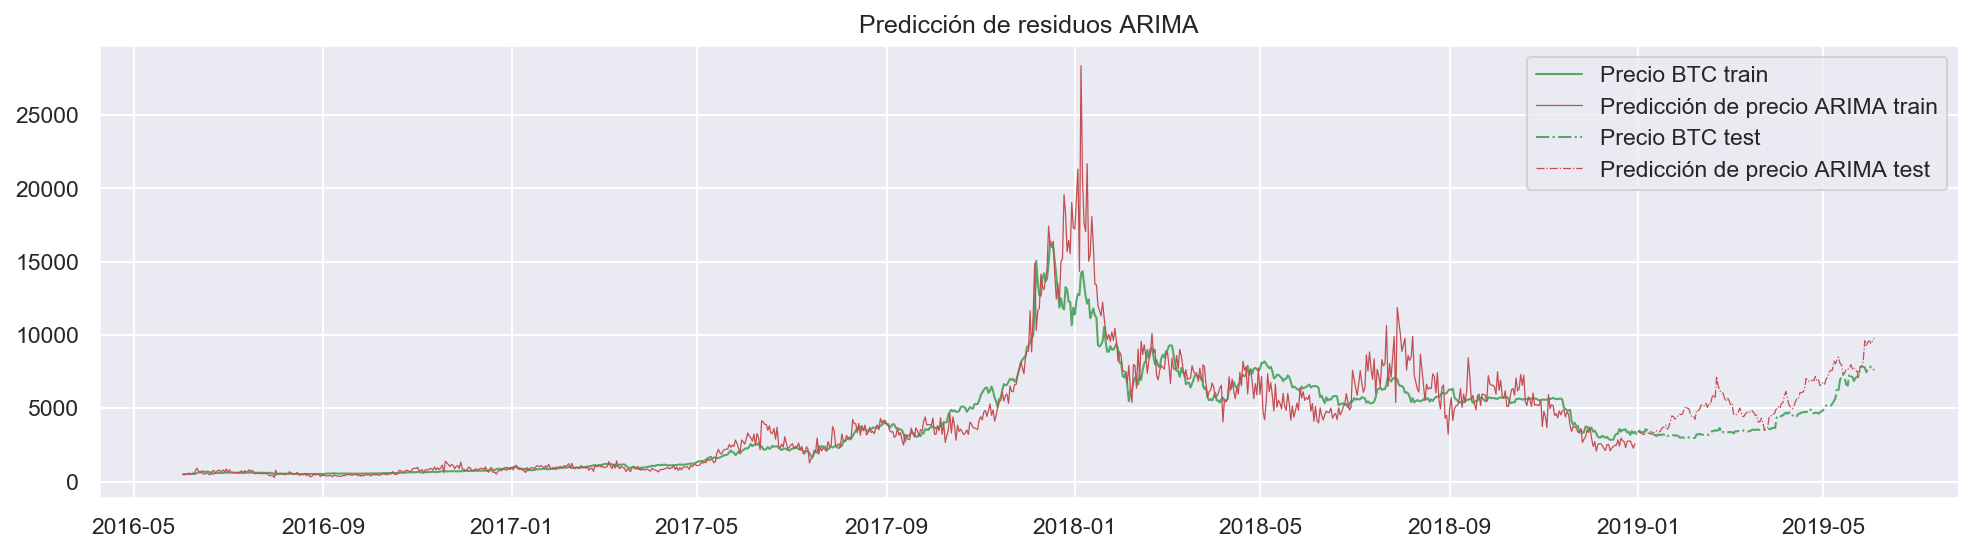

In [233]:
fully_recovered_btc_train = 10**restaured_train_residual_predictions
fully_recovered_btc_test  = 10**restaured_test_residual_predictions

# Plot of predicted values
plt.figure(figsize=(16, 4))
plt.plot(BTC_train_serie, color='g', linewidth=1)
plt.plot(BTC_train_index[:-1], fully_recovered_btc_train, color='r', linewidth=0.6, linestyle='-')
plt.plot(BTC_test_serie, color='g', linewidth=1, linestyle='-.')
plt.plot(BTC_test_index, fully_recovered_btc_test, color='r', linewidth=0.6, linestyle='-.')
plt.legend(['Precio BTC train', 'Predicción de precio ARIMA train', 'Precio BTC test','Predicción de precio ARIMA test'])
plt.title('Predicción de residuos ARIMA')
plt.show()

In [243]:
# Errors on log10
rmse_train = np.sqrt(mean_squared_error(BTC_train_log10[:-1], restaured_train_residual_predictions))
mae_train = mean_absolute_error(BTC_train_log10[:-1], restaured_train_residual_predictions)

rmse_test = np.sqrt(mean_squared_error(BTC_test_log10, restaured_test_residual_predictions))
mae_test = mean_absolute_error(BTC_test_log10, restaured_test_residual_predictions)

print('Train log10 RMSE: ' + str(rmse_train))
print('Train log10 MAE: ' + str(mae_train))

print('Test log10 RMSE: ' + str(rmse_test))
print('Test log10 MAE: ' + str(mae_test))

# Errors on original
rmse_train = np.sqrt(mean_squared_error(BTC_train_serie[:-1], fully_recovered_btc_train))
mae_train = mean_absolute_error(BTC_train_serie[:-1], fully_recovered_btc_train)

rmse_test = np.sqrt(mean_squared_error(BTC_test_serie, fully_recovered_btc_test))
mae_test = mean_absolute_error(BTC_test_serie, fully_recovered_btc_test)

print('Train original RMSE: ' + str(rmse_train))
print('Train original MAE: ' + str(mae_train))

print('Test original RMSE: ' + str(rmse_test))
print('Test original MAE: ' + str(mae_test))

Train log10 RMSE: 0.09701214934092582
Train log10 MAE: 0.07698432327147509
Test log10 RMSE: 0.13604865616913966
Test log10 MAE: 0.11620738117648026
Train original RMSE: 1329.1480506751502
Train original MAE: 709.9881995655172
Test original RMSE: 1500.4731876436324
Test original MAE: 1277.9448620629807


In [207]:
mse_train

1766634.5406135514

# Ethereum ARIMA model

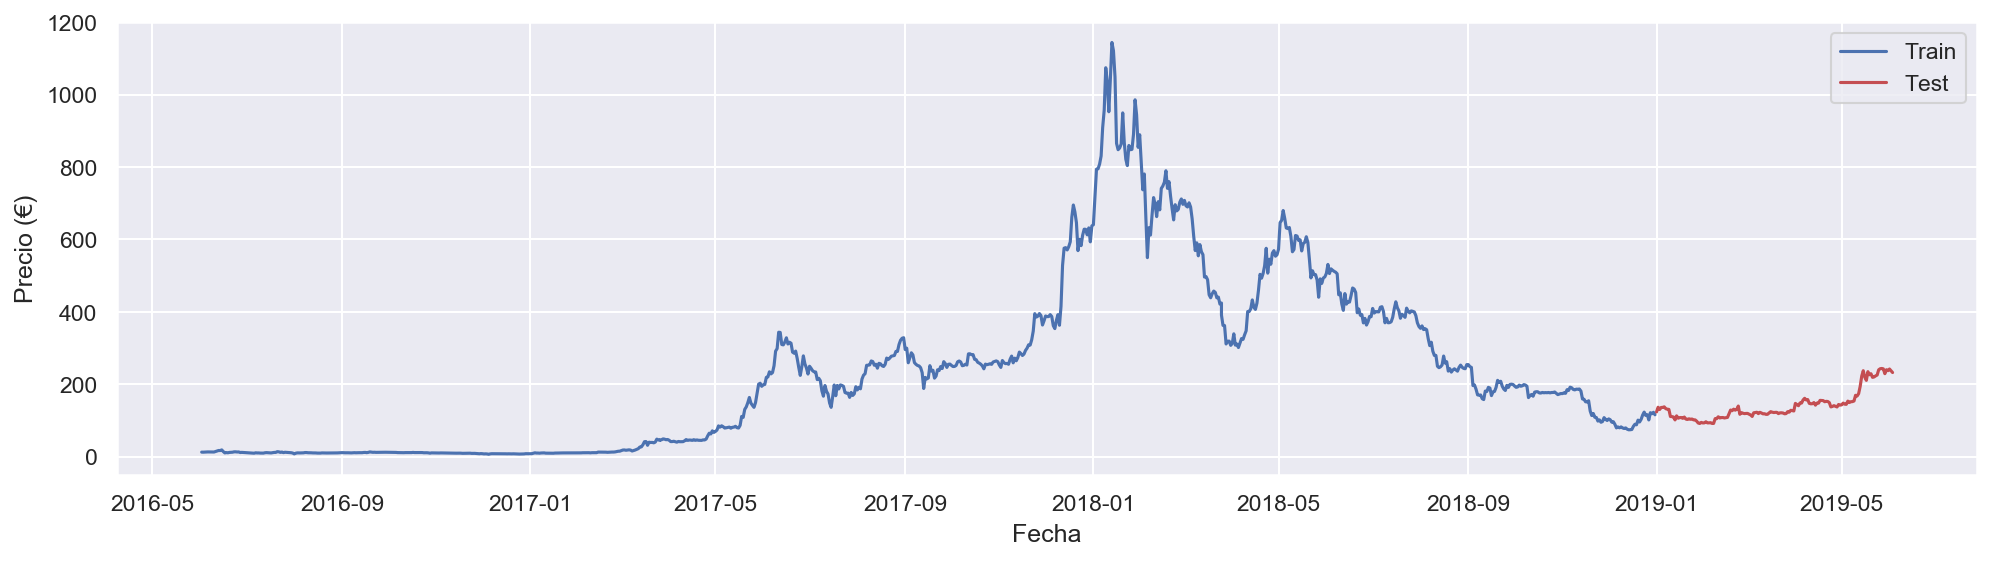

In [245]:
# Train y test
plt.figure(figsize=(16, 4))
plt.plot(ETH_train_serie, color='b')
plt.plot(ETH_test_serie, color='r')
plt.legend(['Train', 'Test'])
plt.xlabel('Fecha')
plt.ylabel('Precio (€)')
plt.show()

## Tendencia

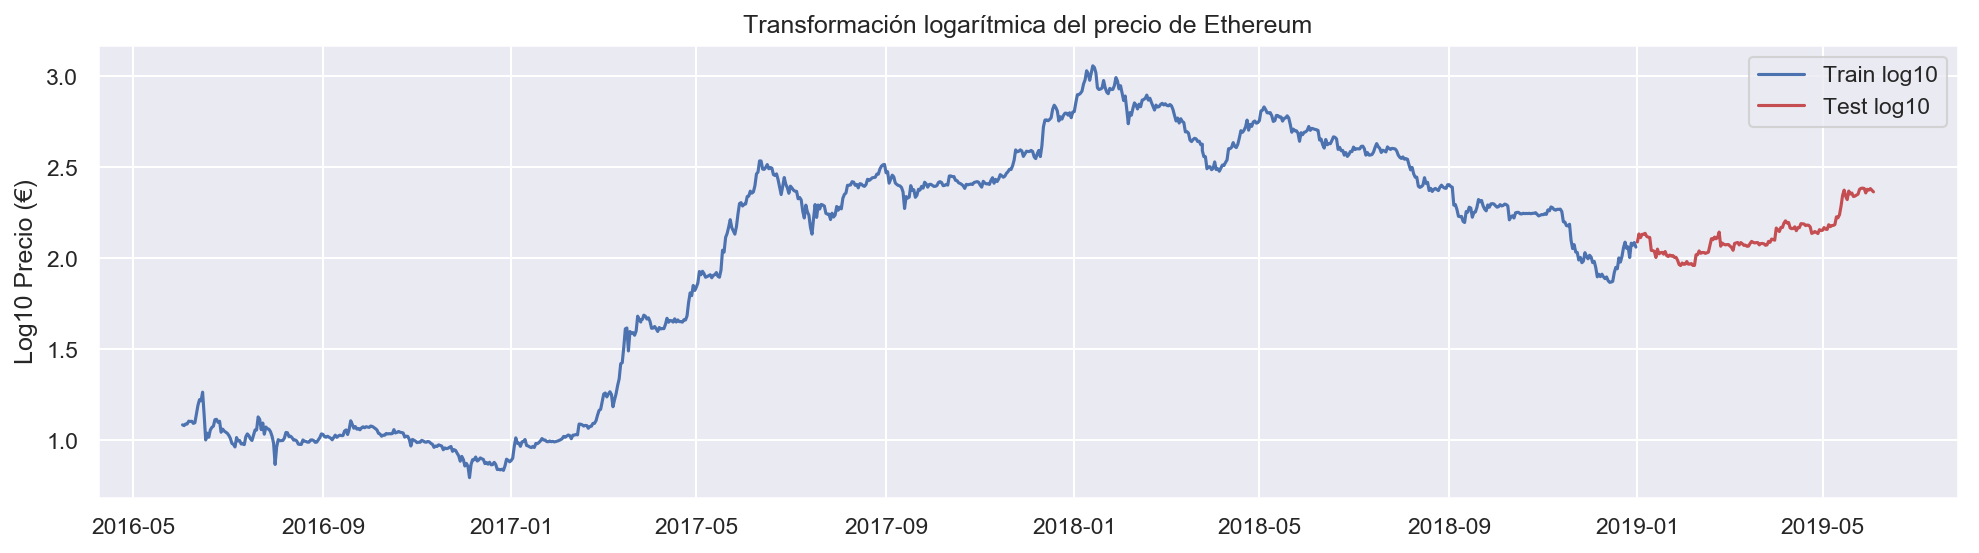

In [259]:
plt.figure(figsize=(16, 4))

ETH_train_log10 = np.log10(ETH_train_serie)
ETH_test_log10  = np.log10(ETH_test_serie)
plt.plot(ETH_train_log10, color='b')
plt.plot(ETH_test_log10, color='r')
plt.ylabel('Log10 Precio (€)')
plt.title('Transformación logarítmica del precio de Ethereum')
plt.legend(['Train log10', 'Test log10'])

plt.show();

## Filtros suavizado

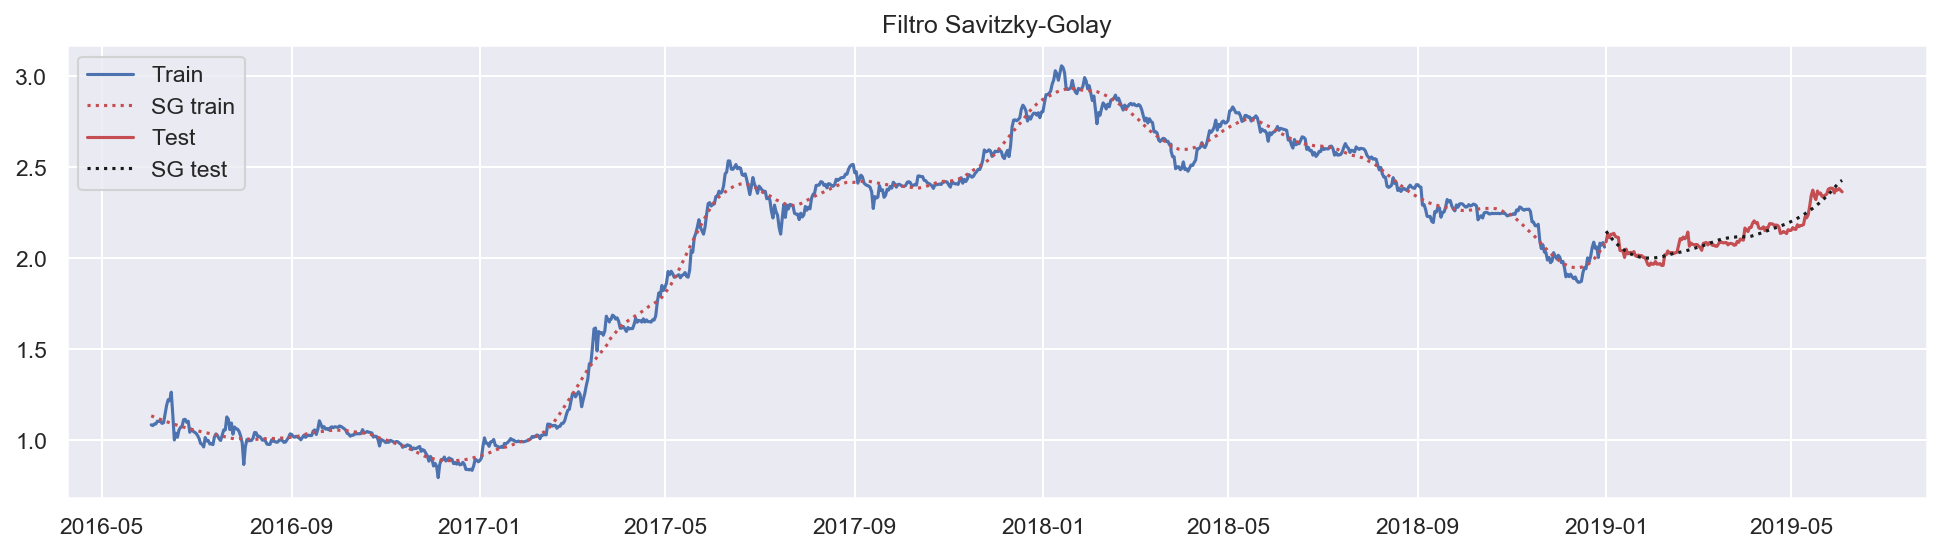

In [252]:
# Savitzky-Golay
w_length = 91
order = 3

ETH_train_SG_filter = savgol_filter(ETH_train_log10.values.flatten(), window_length=w_length, polyorder=order)
ETH_test_SG_filter = savgol_filter(ETH_test_log10.values.flatten(), window_length=w_length, polyorder=order)

plt.figure(figsize=(16, 4))
plt.plot(ETH_train_index, ETH_train_log10, color='b')
plt.plot(ETH_train_index, ETH_train_SG_filter, linestyle=':', color='r')
plt.plot(ETH_test_index, ETH_test_log10, color='r')
plt.plot(ETH_test_index, ETH_test_SG_filter, linestyle=':', color='k')
plt.title('Filtro Savitzky-Golay (ETH)')

plt.legend(['Train', 'SG train', 'Test', 'SG test'])

plt.show();

## Interpolación cuadrática

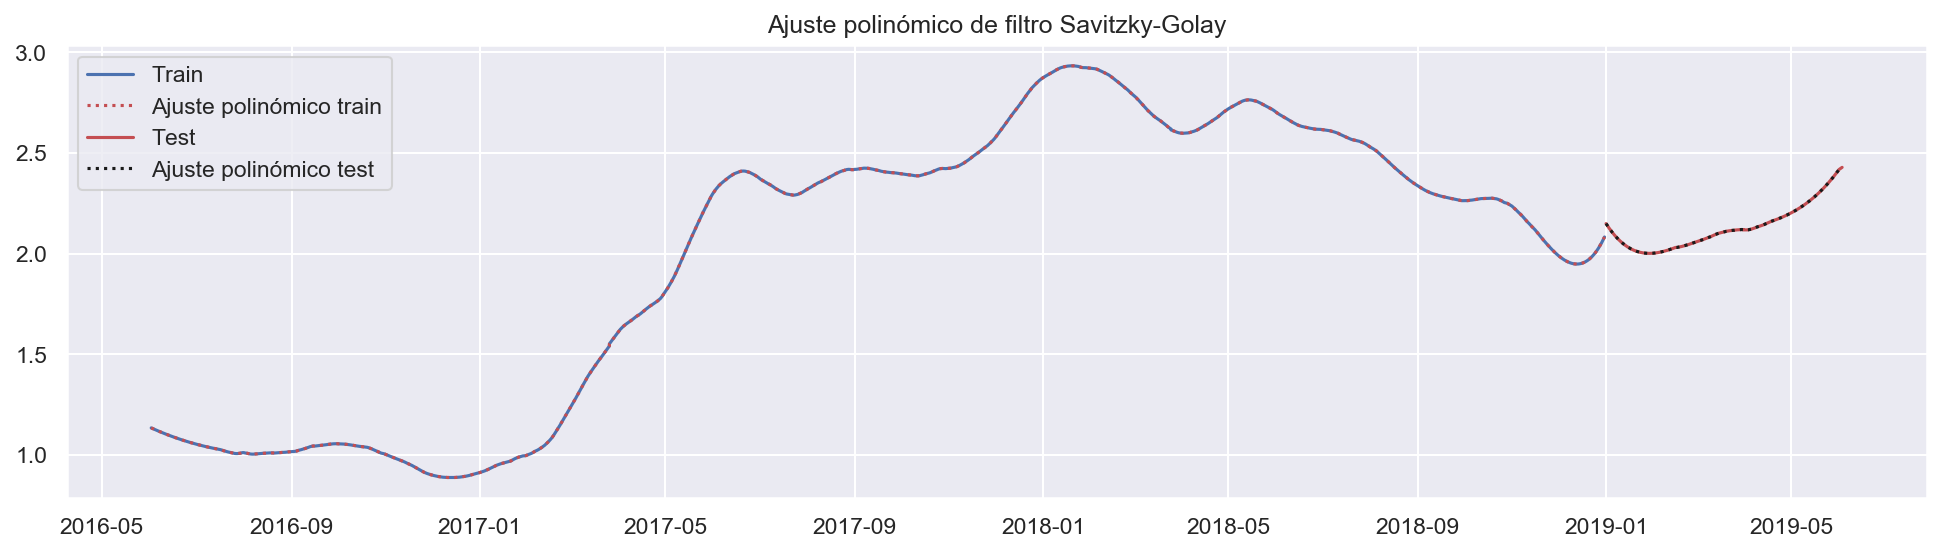

In [256]:
ETH_train_interpolation = interpolate.interp1d(range(len(ETH_train_SG_filter)), ETH_train_SG_filter, kind='quadratic')
train_interp_values = test_interp_values = ETH_train_interpolation(range(len(ETH_train_SG_filter)))
ETH_test_interpolation = interpolate.interp1d(range(len(ETH_test_SG_filter)), ETH_test_SG_filter, kind='quadratic')
test_interp_values = ETH_test_interpolation(range(len(ETH_test_SG_filter)))


plt.figure(figsize=(16, 4))
plt.plot(ETH_train_index, ETH_train_SG_filter, color='b')
plt.plot(ETH_train_index, train_interp_values, linestyle=':', color='r')
plt.plot(ETH_test_index, ETH_test_SG_filter, color='r')
plt.plot(ETH_test_index, test_interp_values, linestyle=':', color='k')
plt.title('Ajuste polinómico de filtro Savitzky-Golay (ETH)')
plt.legend(['Train', 'Ajuste polinómico train', 'Test', 'Ajuste polinómico test'])

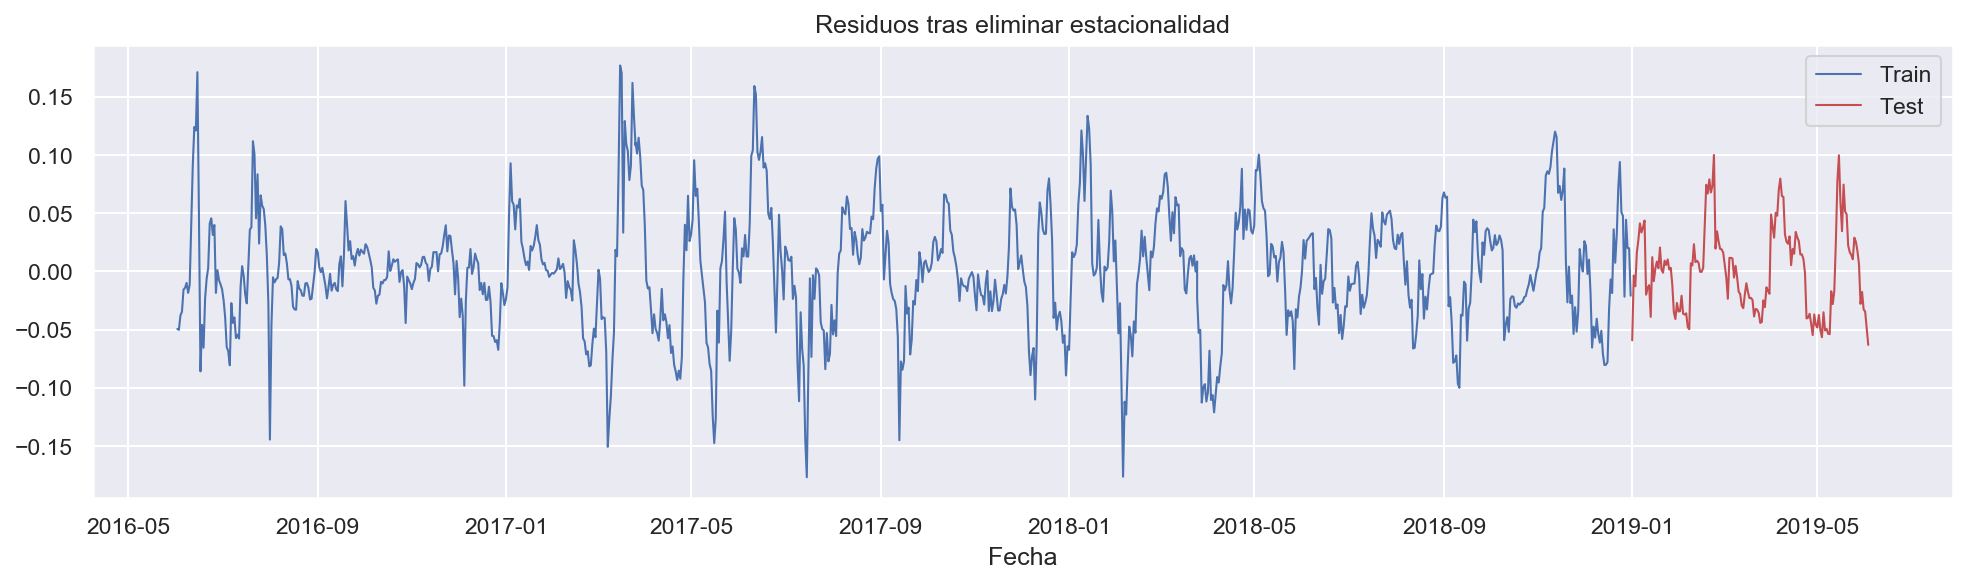

In [257]:
ETH_train_notend = ETH_train_log10.values.flatten() - train_interp_values
ETH_test_notend  = ETH_test_log10.values.flatten() - test_interp_values

plt.figure(figsize=(16, 4))
plt.plot(ETH_train_index, ETH_train_notend, color='b', linewidth=1)
plt.plot(ETH_test_index,  ETH_test_notend, color='r', linewidth=1)
plt.title('Residuos tras eliminar estacionalidad (ETH)')

plt.xlabel('Fecha')
plt.legend(['Train', 'Test'])

plt.show()

## Normalidad de residuos

In [261]:
# Normality
from scipy.stats import shapiro, jarque_bera

# Shapiro-Wilk test (H0 = Normal distribution)
p_value_sw, stat = shapiro(ETH_train_notend)
print(p_value_sw)

# Jarque-Bera to test skewness and kurtosis
stat_jb, p_value_jb = jarque_bera(ETH_train_notend)
print(p_value_jb)


0.9893213510513306
3.248376290176935e-08


### Histograma

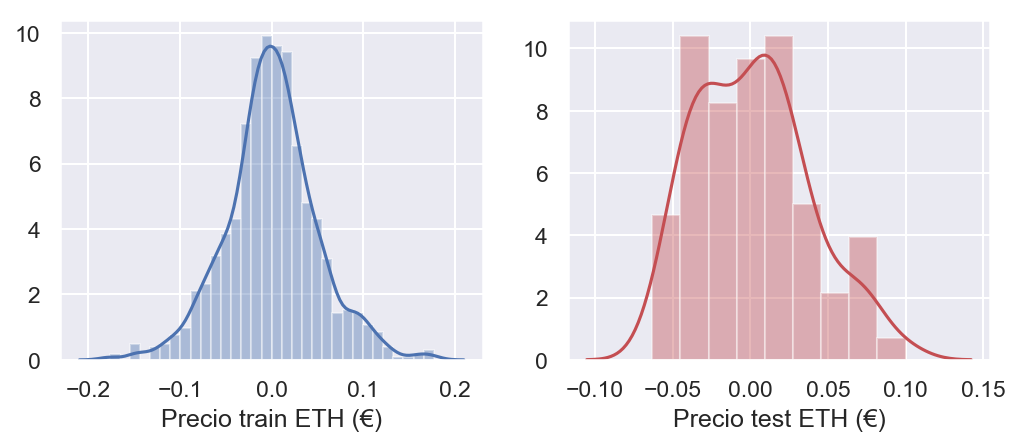

In [263]:
# Histograms
plt.figure(figsize=(8, 3))
plt.subplot(1, 2, 1)
sns.distplot(ETH_train_notend, axlabel='Precio train ETH (€)', color='b');
plt.subplot(1, 2, 2)
sns.distplot(ETH_test_notend, axlabel='Precio test ETH (€)', color='r');
plt.show()

### QQ-plot

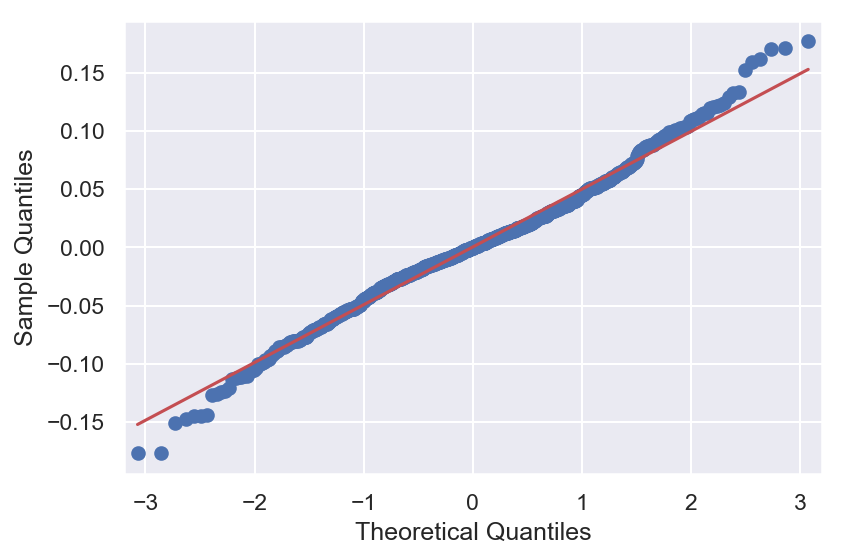

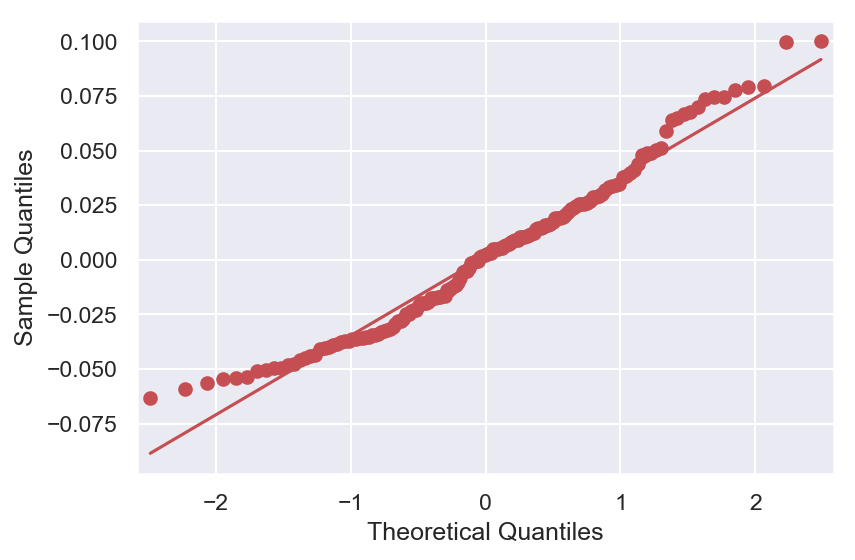

In [265]:
## QQ-plots
qqplot(ETH_train_notend, line='s', color='b');
qqplot(ETH_test_notend, line='s', color='r');

## Estacionaridad

In [266]:
# Dickey-Fuller Test - ETH with no trend
# H0: Time serie has unit root, non-stationary
# H1: Time serie has not unit root, stationary

stat_df_train, p_value_ad_train, _, _, conf_levels_train, _ = adfuller(ETH_train_notend)
stat_df_test, p_value_ad_test, _, _, conf_levels_test, _ = adfuller(ETH_test_notend)
print(p_value_ad_train)
print(p_value_ad_test)

1.114504683704181e-14
0.008935247230771598


El test de Dickey-Fuller indica que, tras eliminar la tendencia de la serie, la componente residual resultante en train y test no contienen raices unitarias, resultando en series estacionarias aptas para ser modeladas.

## Modelado

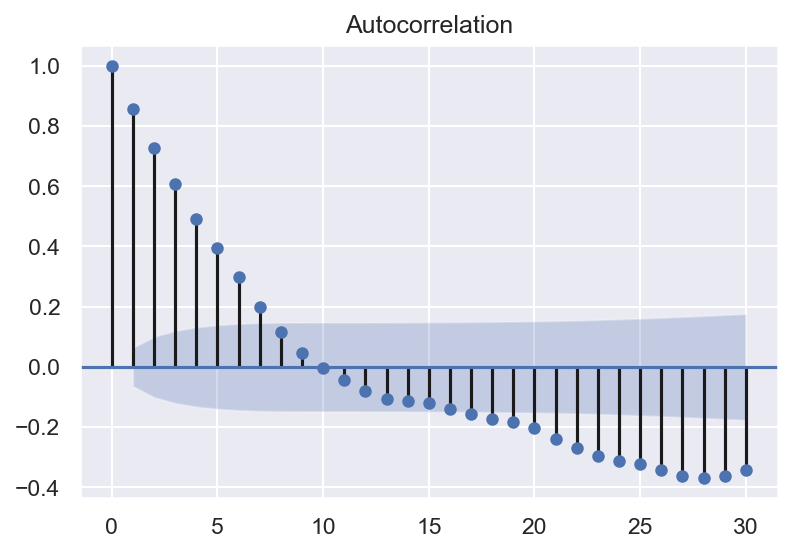

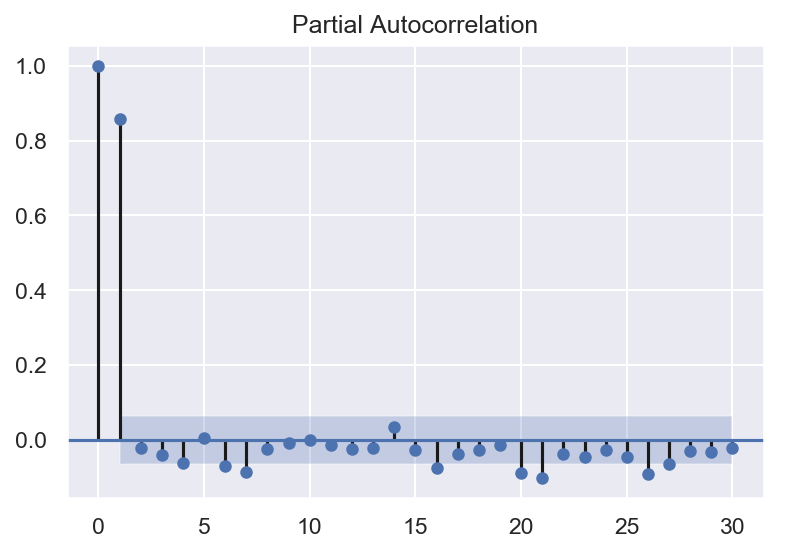

In [268]:
## ACF and PACF plots - ETH
plot_acf(ETH_train_notend, lags=30)
plot_pacf(ETH_train_notend, lags=30)
plt.show()

In [308]:
# ARIMA model ETH
arima_order = (1, 0, 0)
arima_model = ARIMA(ETH_train_notend, order=arima_order)
arima_model_fitted = arima_model.fit(disp=0)

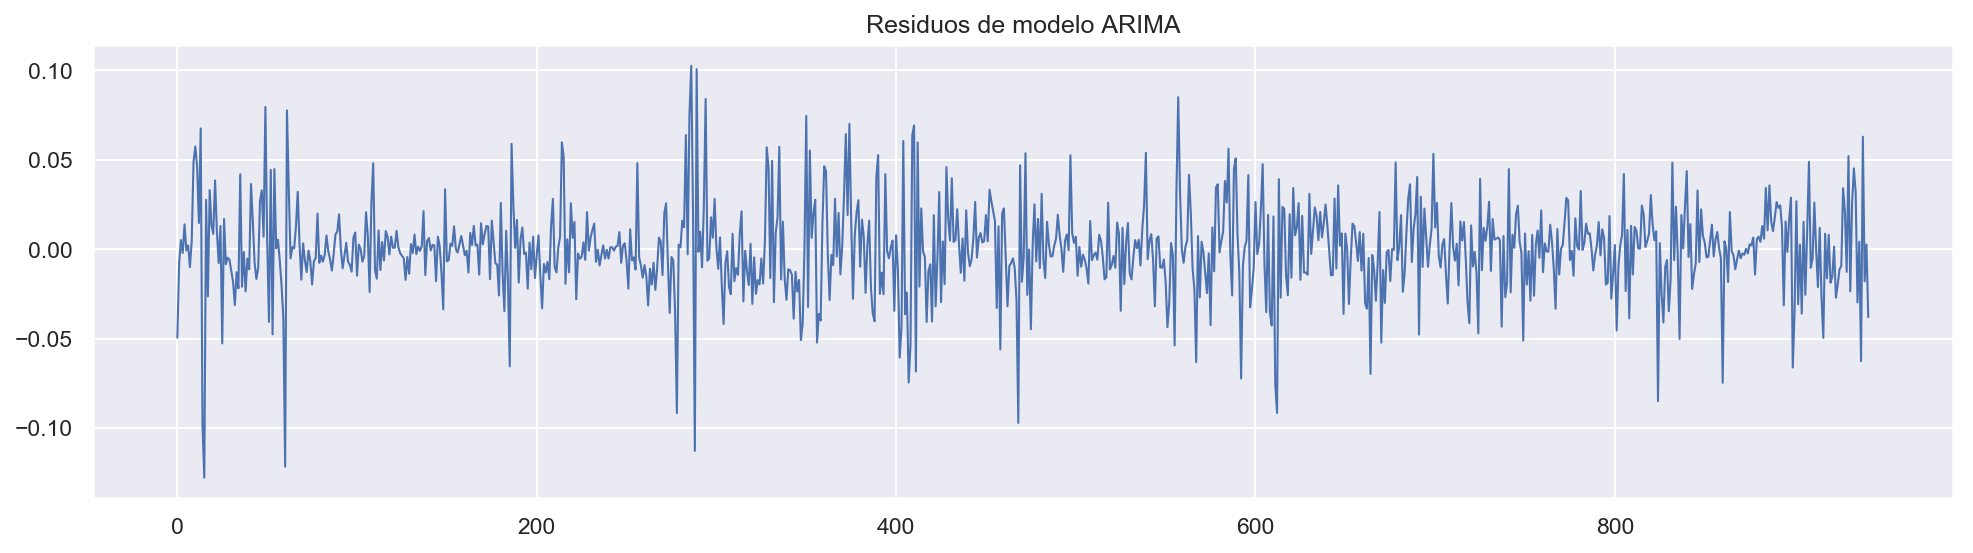

0.955044686794281


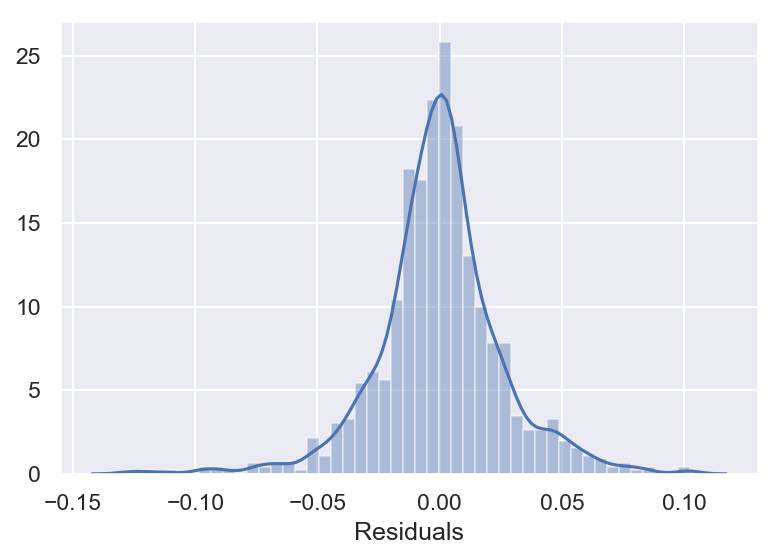

In [309]:
# Get residuals and evaluate normality
arima_res = arima_model_fitted.resid

plt.figure(figsize=(16, 4))
plt.plot(arima_res, color='b', linewidth=1)
plt.title('Residuos de modelo ARIMA')
plt.show()

sns.distplot(arima_res, axlabel='Residuals', color='b');
p_value_sw_res, stat = shapiro(arima_res)
print(p_value_sw_res)


In [311]:
# Errors
# MSE
mse_train = mean_squared_error(ETH_train_notend, arima_res)

# MAE
mae_train = mean_absolute_error(ETH_train_notend, arima_res)

print(mse_train)
print(mae_train)

0.0018092601586805351
0.03197930556080525


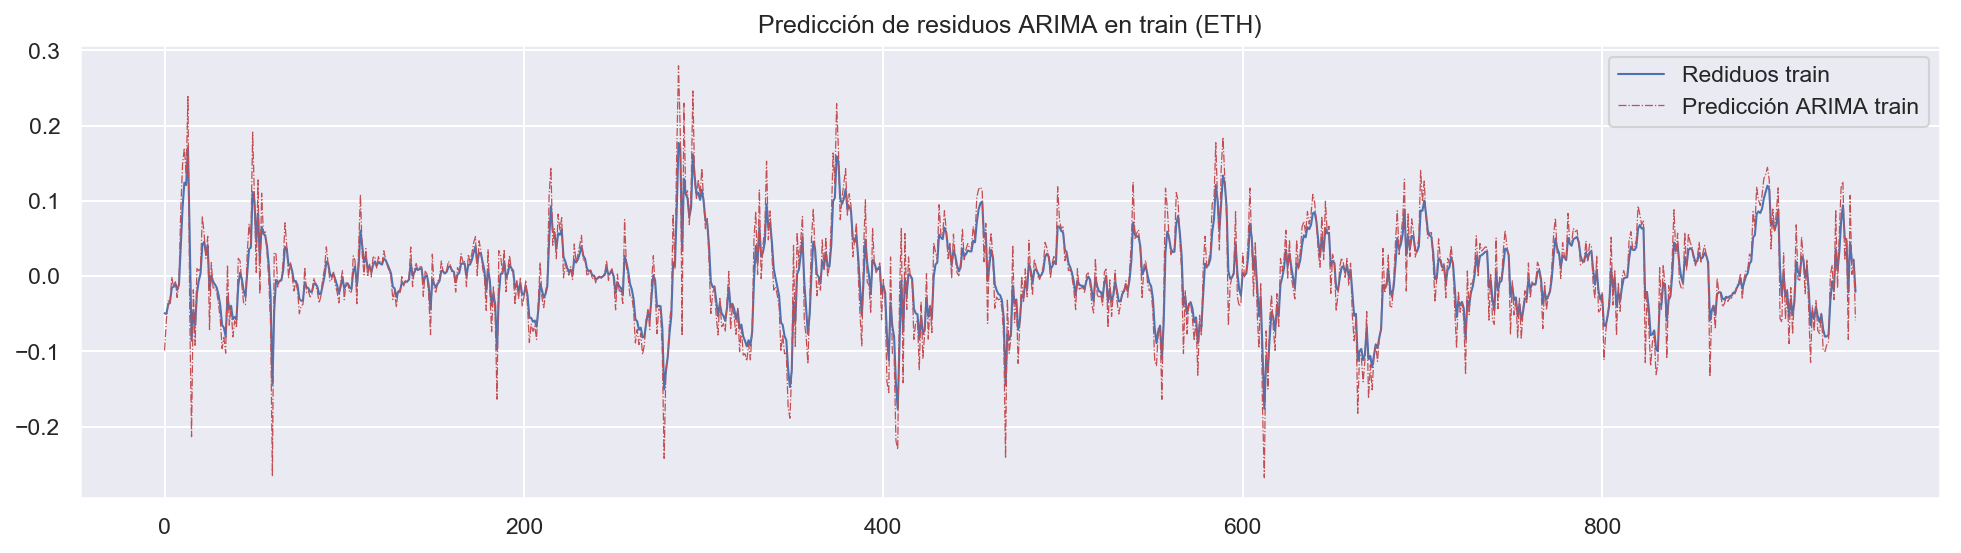

In [342]:
# Residual train adjustment
ETH_train_adjust = ETH_train_notend + arima_res

plt.figure(figsize=(16, 4))
plt.plot(ETH_train_notend, color='b', linewidth=1)
plt.plot(ETH_train_adjust, color='r', linewidth=0.6, linestyle='-.')
plt.legend(['Rediduos train', 'Predicción ARIMA train'])
plt.title('Predicción de residuos ARIMA en train (ETH)')
plt.show()

In [313]:
# Test predictions on Ethereum
arima_test = ARIMA(BTC_train_notend_nosta, order=arima_order)
arima_test = arima_test.fit(disp=0)
arima_test_predictions = arima_test.forecast(len(BTC_test_notend_nosta))

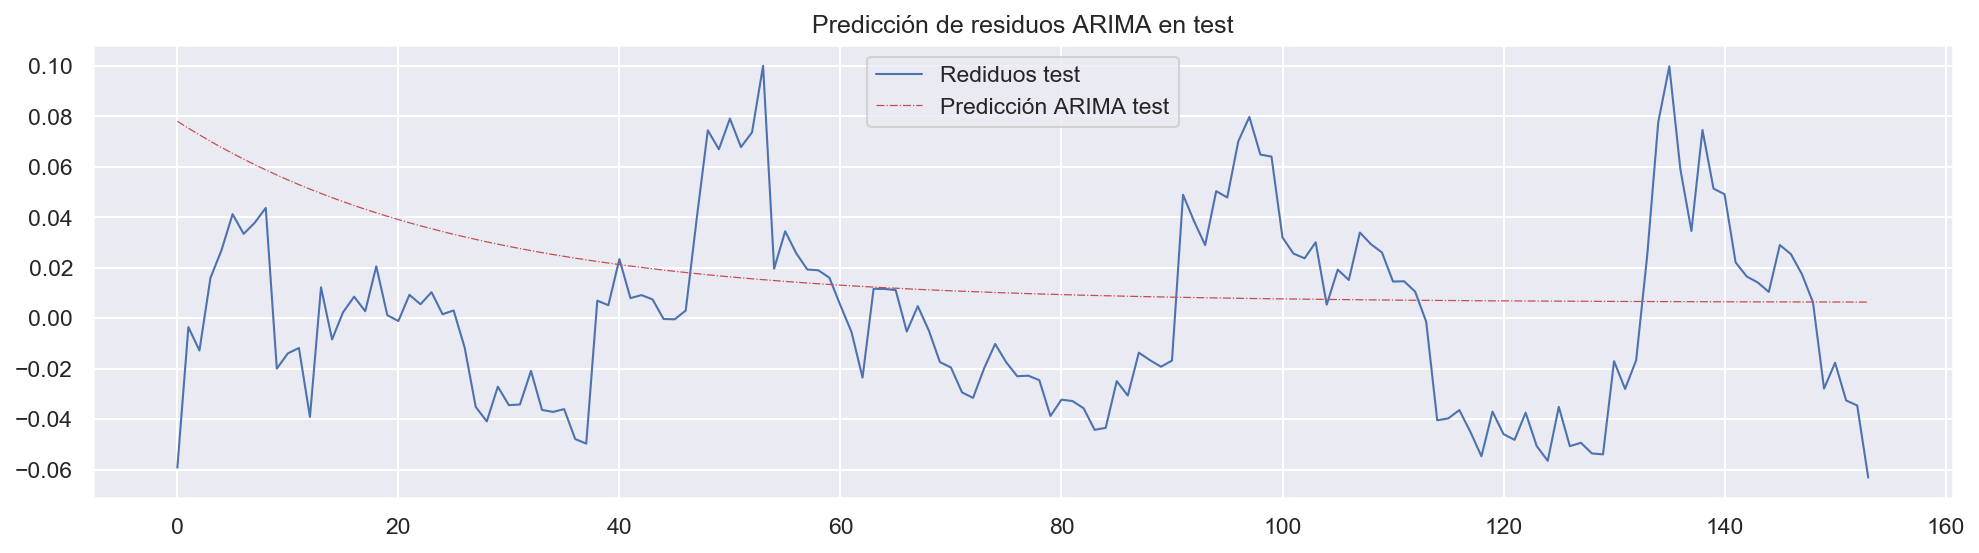

In [314]:
# Plot real and predicted test on residuals
plt.figure(figsize=(16, 4))
plt.plot(ETH_test_notend, color='b', linewidth=1)
plt.plot(arima_test_predictions[0], color='r', linewidth=0.6, linestyle='-.')
plt.legend(['Rediduos test', 'Predicción ARIMA test'])
plt.title('Predicción de residuos ARIMA en test')
plt.show()

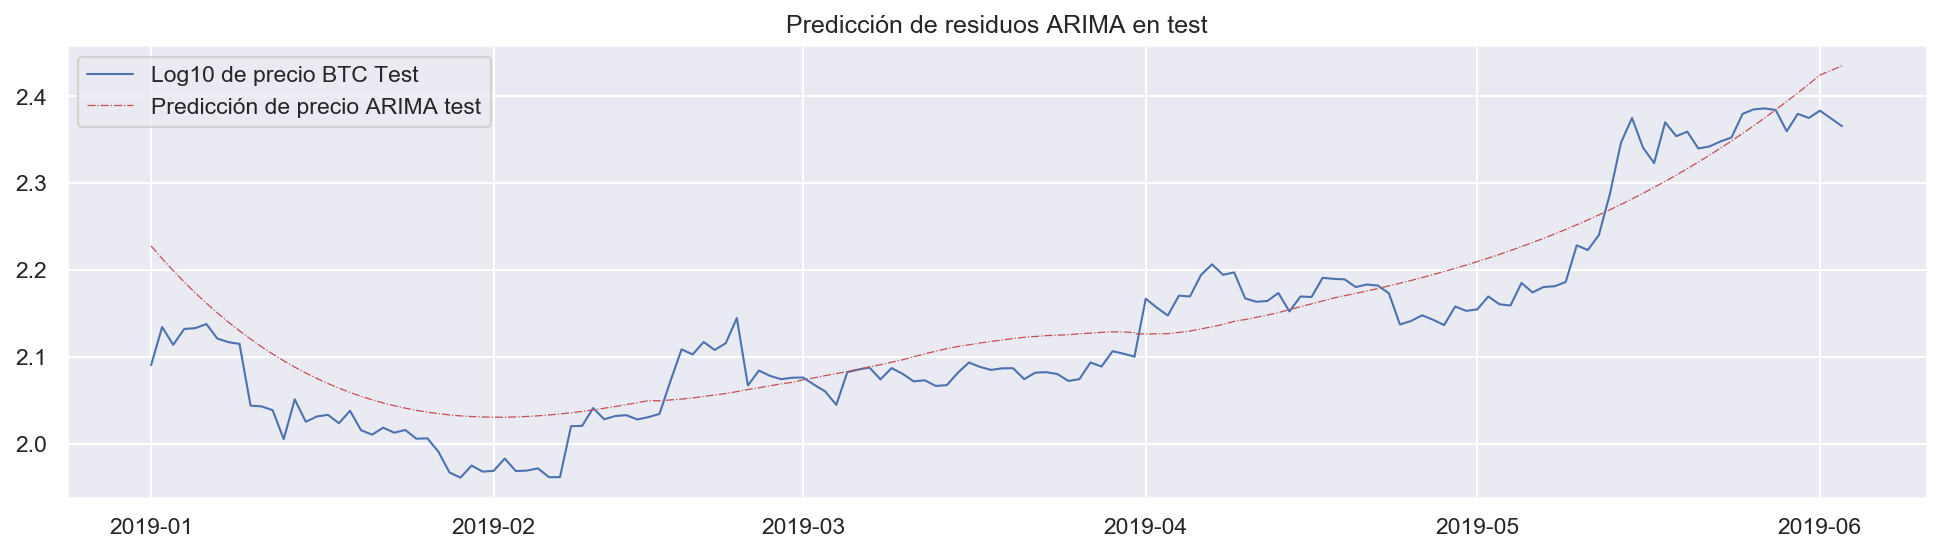

In [341]:
## Include transformations on train residual predictions (ETH)
restaured_train_residual_predictions = ETH_train_adjust + train_interp_values

## Include transformations on test residual predictions (ETH)
restaured_test_residual_predictions = arima_test_predictions[0] + test_interp_values

# Plot
plt.figure(figsize=(16, 4))
plt.plot(ETH_test_index, ETH_test_log10, color='b', linewidth=1)
plt.plot(ETH_test_index, restaured_test_residual_predictions, color='r', linewidth=0.6, linestyle='-.')
plt.legend(['Log10 de precio BTC Test', 'Predicción de precio ARIMA test'])
plt.title('Predicción de residuos ARIMA en test')
plt.show()

## Estacionalidad

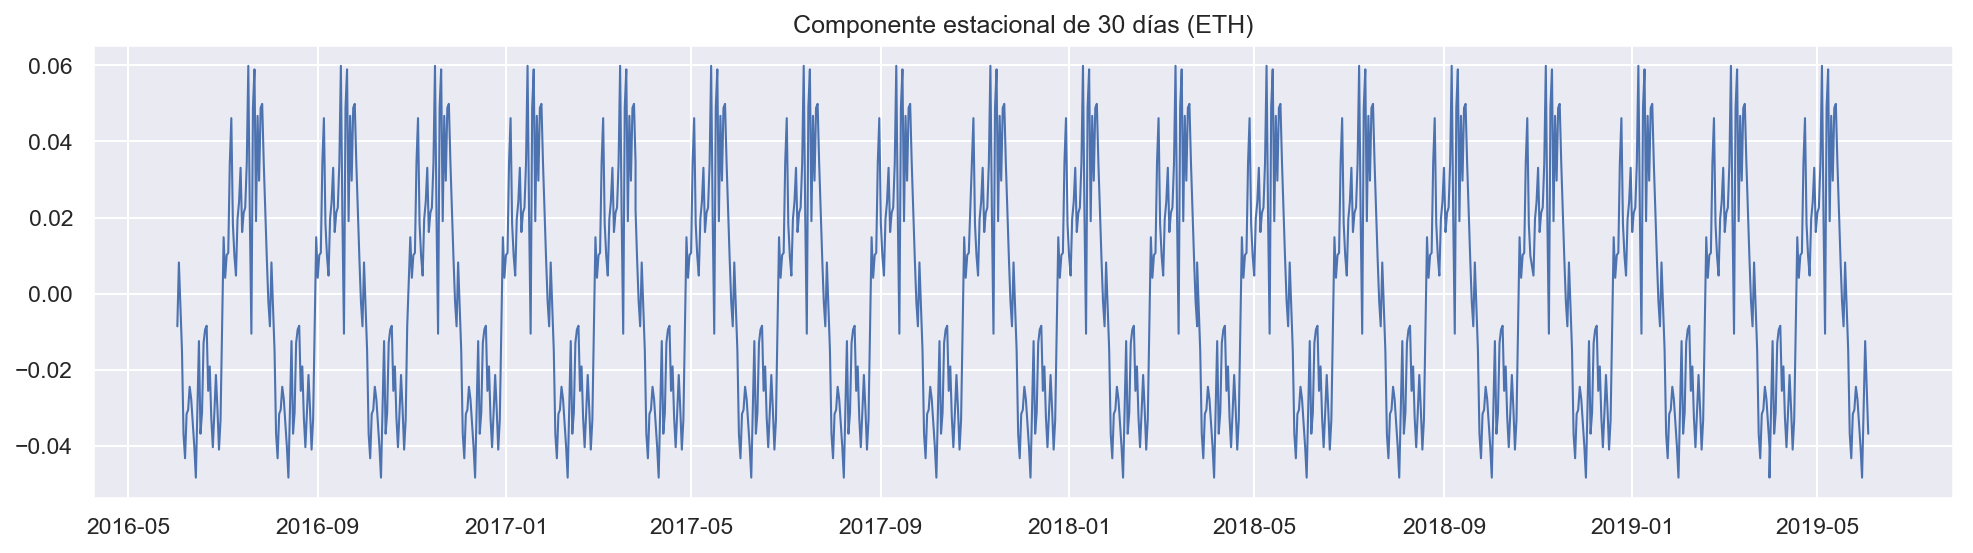

In [361]:
## Estacionalidad ETH - 206 días
ETH_decompose = seasonal_decompose(ETH_log, model='aditive', freq=60)
ETH_seasonality = ETH_decompose.seasonal
plt.figure(figsize=(16, 4))
plt.title('Componente estacional de 30 días (ETH)')
plt.plot(ETH_seasonality, color='b', linewidth=1)
plt.show()

In [362]:
## Eliminar estacionalidad
train_stacionality = ETH_seasonality[:len(ETH_train_notend)].values
test_stacionality  = ETH_seasonality[len(ETH_train_notend):].values
ETH_train_notend_nosta = ETH_train_notend - train_stacionality.flatten()
ETH_test_notend_nosta  = ETH_test_notend - test_stacionality.flatten()

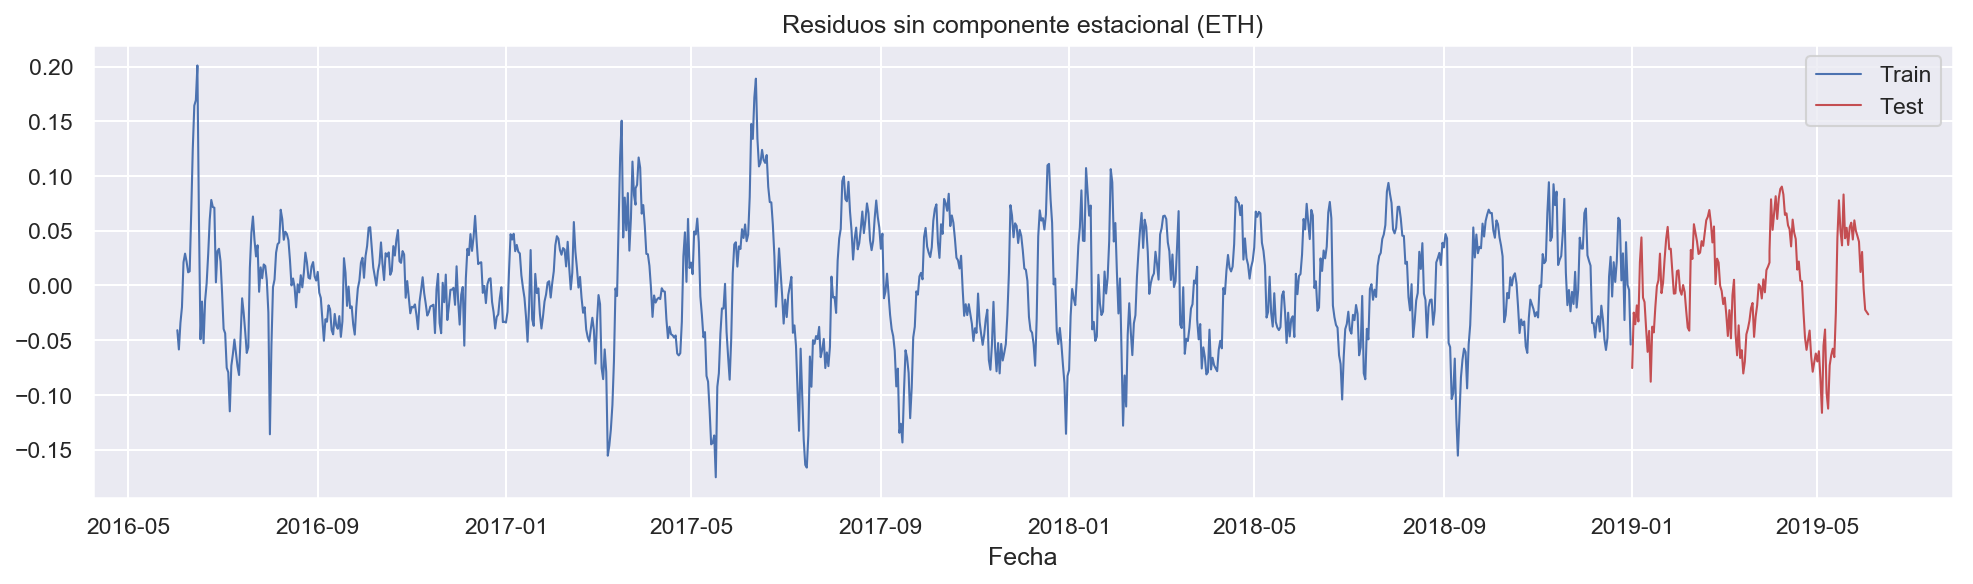

In [363]:
## Representación
plt.figure(figsize=(16, 4))
plt.plot(ETH_train_index, ETH_train_notend_nosta, color='b', linewidth=1)
plt.plot(ETH_test_index,  ETH_test_notend_nosta, color='r', linewidth=1)
plt.title('Residuos sin componente estacional (ETH)')

plt.xlabel('Fecha')
plt.legend(['Train', 'Test'])

plt.show()

In [364]:
stat_df_train, p_value_ad_train, _, _, conf_levels_train, _ = adfuller(ETH_train_notend_nosta)
stat_df_test, p_value_ad_test, _, _, conf_levels_test, _ = adfuller(ETH_test_notend_nosta)
print(p_value_ad_train)
print(p_value_ad_test)

1.934954658688288e-14
0.0011731018947103275


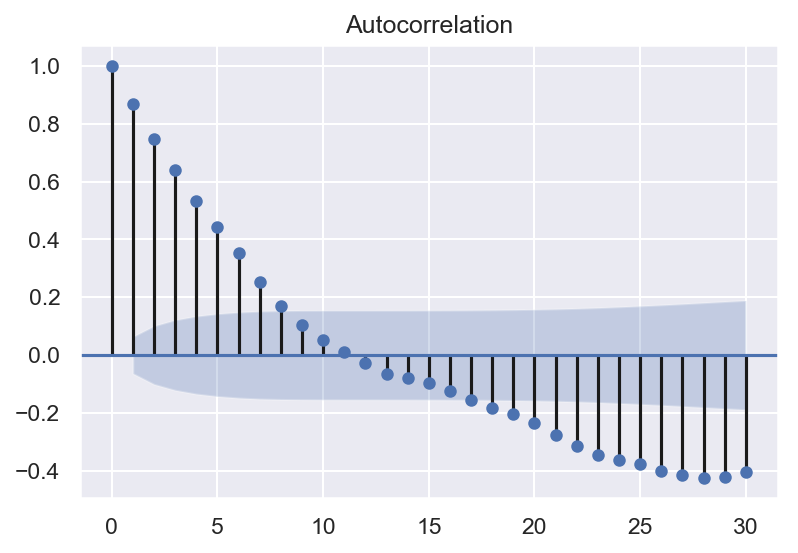

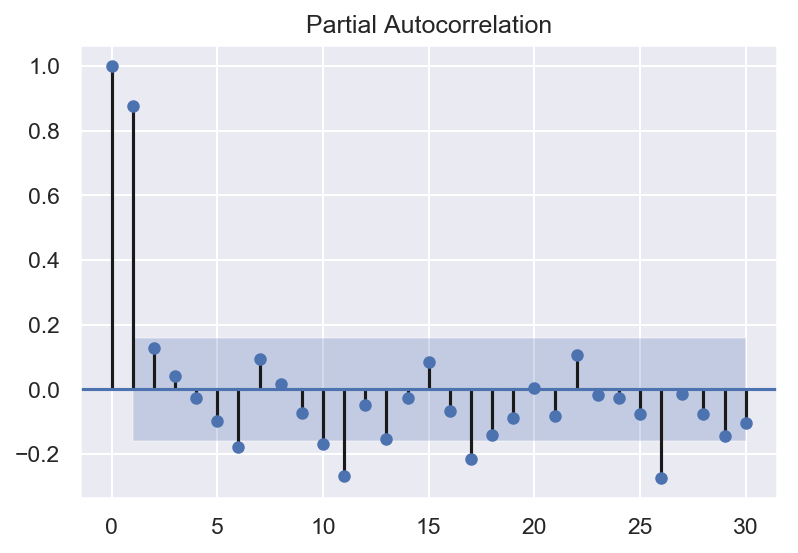

In [365]:
## ACF and PACF plots - ETH
plot_acf(ETH_train_notend_nosta, lags=30)
plot_pacf(ETH_test_notend_nosta, lags=30)
plt.show()

Tras eliminar la estacionalidad, el gráfico ACF sigue mostrando un comportamiento típico de una serie no estacionaria.

In [375]:
# ARIMA model
arima_order = (1, 0, 0)
arima_model = ARIMA(ETH_train_notend_nosta, order=arima_order)
arima_model_fitted = arima_model.fit(disp=0)

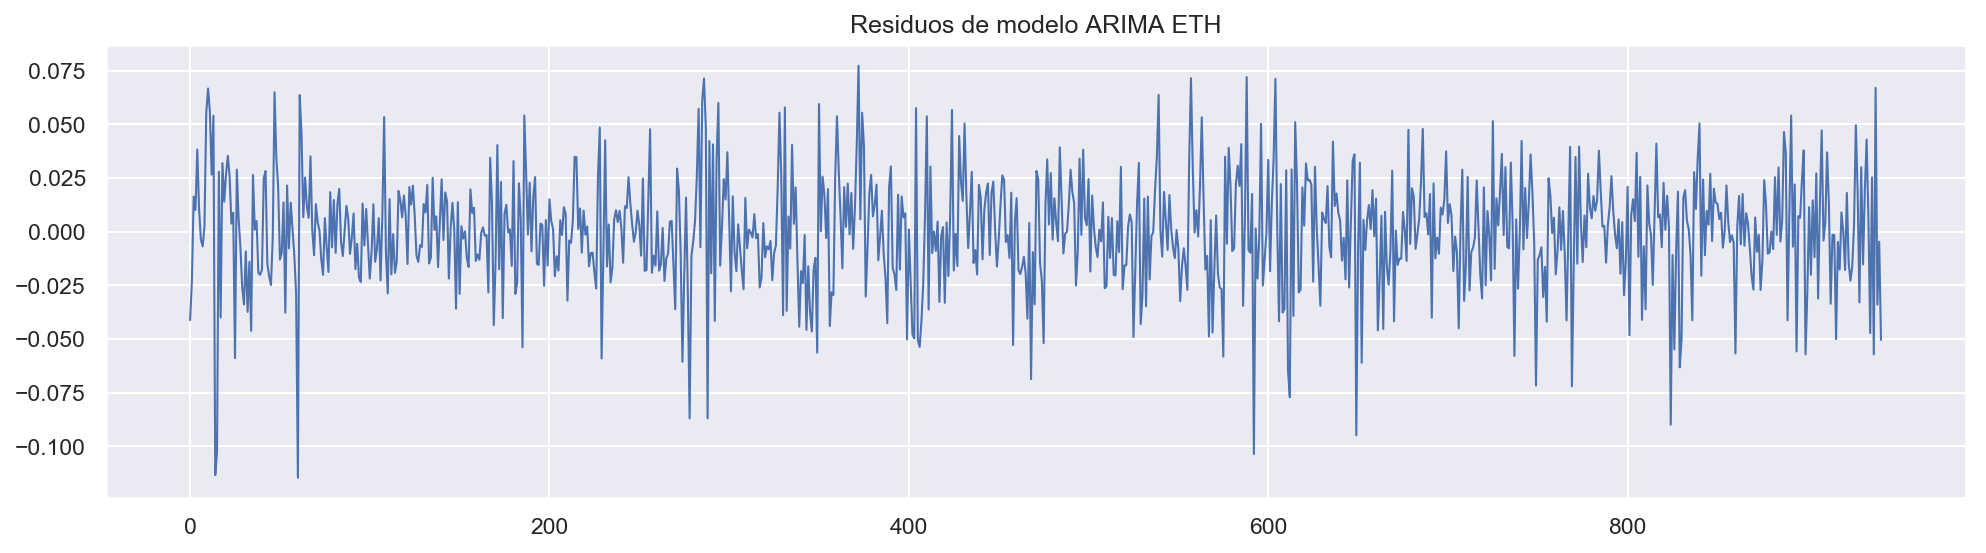

0.9825310707092285


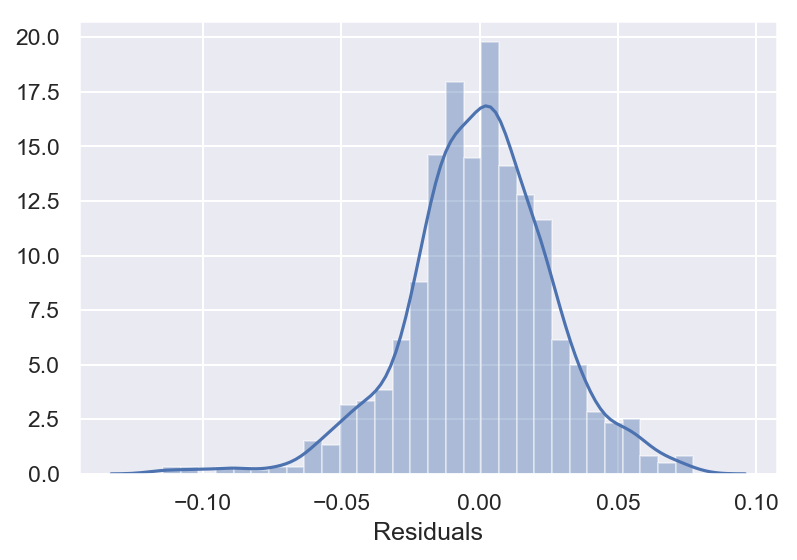

In [376]:
# Get residuals and evaluate normality
arima_res = arima_model_fitted.resid

plt.figure(figsize=(16, 4))
plt.plot(arima_res, color='b', linewidth=1)
plt.title('Residuos de modelo ARIMA ETH')
plt.show()

sns.distplot(arima_res, axlabel='Residuals', color='b');
p_value_sw_res, stat = shapiro(arima_res)
print(p_value_sw_res)

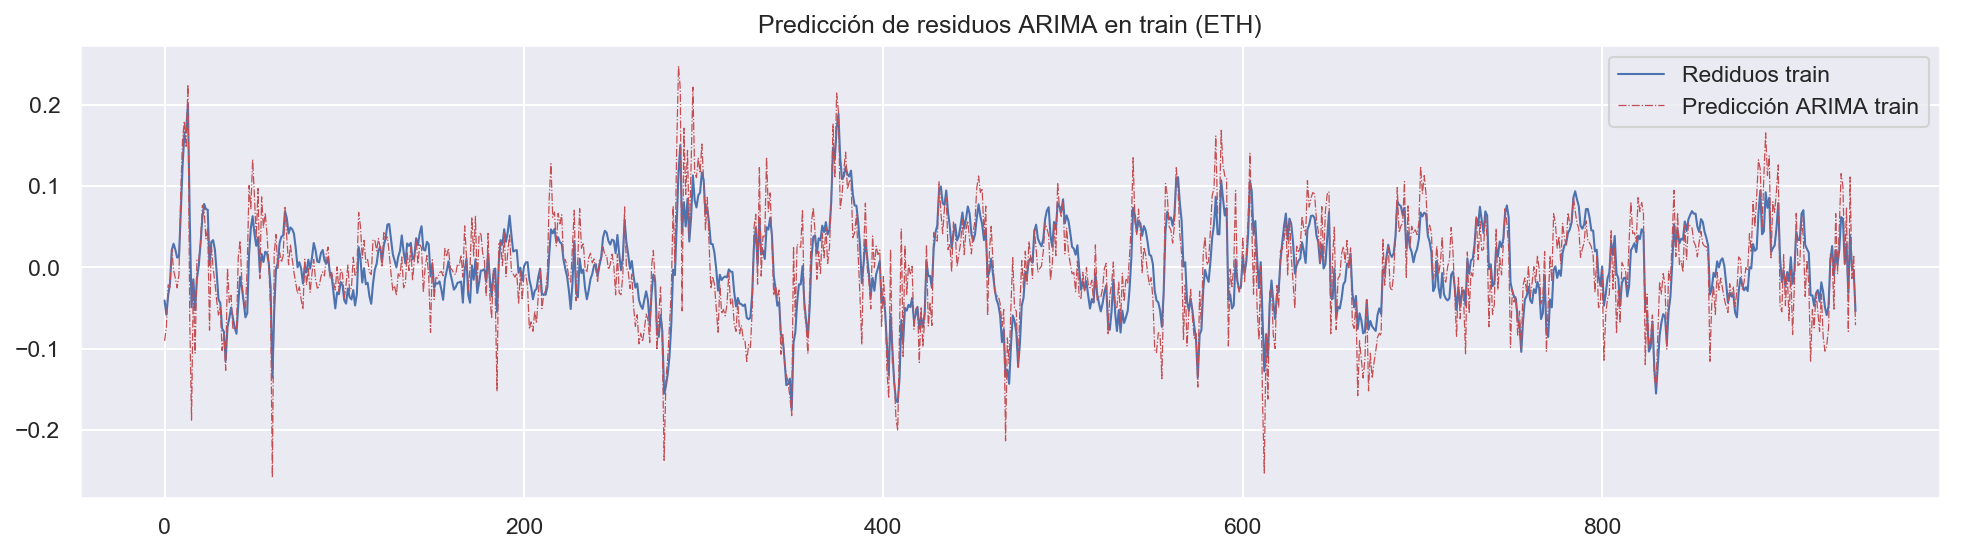

In [377]:
# Residual train adjustment
ETH_train_adjust = ETH_train_notend_nosta + train_stacionality.flatten() + arima_res

plt.figure(figsize=(16, 4))
plt.plot(ETH_train_notend_nosta, color='b', linewidth=1)
plt.plot(ETH_train_adjust, color='r', linewidth=0.6, linestyle='-.')
plt.legend(['Rediduos train', 'Predicción ARIMA train'])
plt.title('Predicción de residuos ARIMA en train (ETH)')
plt.show()

In [378]:
# Run test predictions
arima_test = ARIMA(ETH_train_notend_nosta, order=arima_order)
arima_test = arima_test.fit(disp=0)
arima_test_predictions = arima_test.forecast(len(BTC_test_notend_nosta))

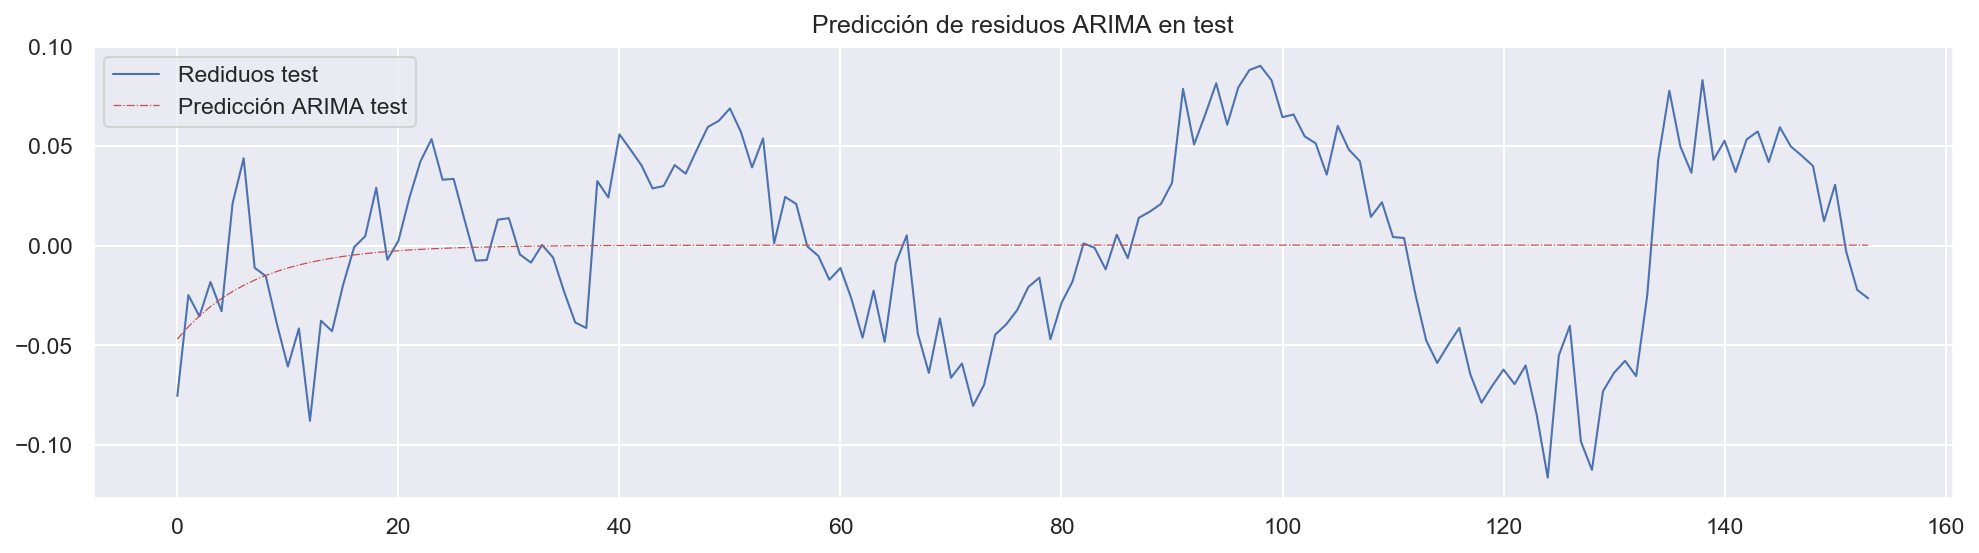

In [380]:
# Plot real and predicted test on residuals
plt.figure(figsize=(16, 4))
plt.plot(ETH_test_notend_nosta, color='b', linewidth=1)
plt.plot(arima_test_predictions[0], color='r', linewidth=0.6, linestyle='-.')
plt.legend(['Rediduos test', 'Predicción ARIMA test'])
plt.title('Predicción de residuos ARIMA en test')
plt.show()

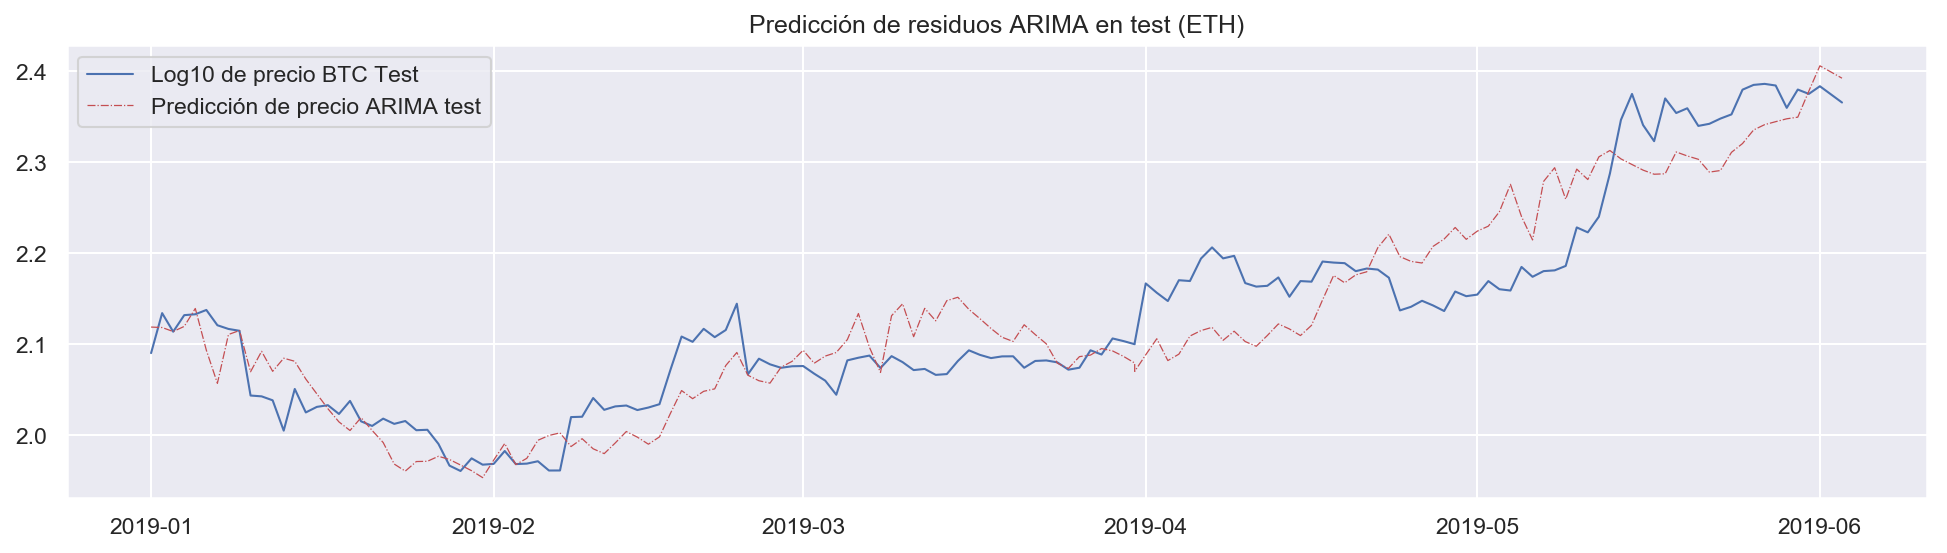

In [382]:
## Include transformations on train residual predictions
restaured_train_residual_predictions = ETH_train_adjust + train_stacionality.flatten() + train_interp_values

## Include transformations on test residual predictions
restaured_test_residual_predictions = arima_test_predictions[0] + test_stacionality.flatten() + test_interp_values

plt.figure(figsize=(16, 4))
plt.plot(ETH_test_index, ETH_test_log10, color='b', linewidth=1)
plt.plot(ETH_test_index, restaured_test_residual_predictions, color='r', linewidth=0.6, linestyle='-.')
plt.legend(['Log10 de precio BTC Test', 'Predicción de precio ARIMA test'])
plt.title('Predicción de residuos ARIMA en test (ETH)')
plt.show()

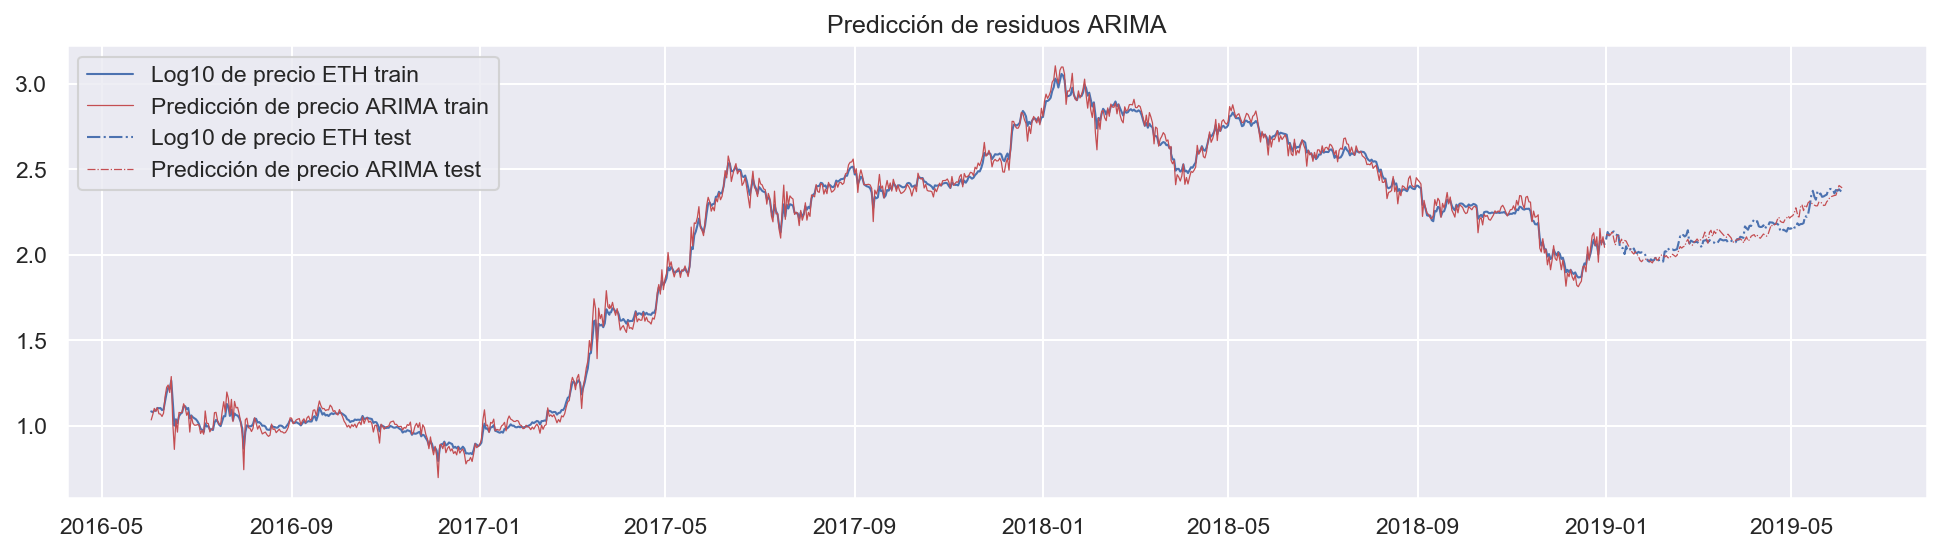

In [384]:
# Plot of predicted values
plt.figure(figsize=(16, 4))
plt.plot(ETH_train_index, ETH_train_log10, color='b', linewidth=1)
plt.plot(ETH_train_index, restaured_train_residual_predictions, color='r', linewidth=0.6, linestyle='-')
plt.plot(ETH_test_index, ETH_test_log10, color='b', linewidth=1, linestyle='-.')
plt.plot(ETH_test_index, restaured_test_residual_predictions, color='r', linewidth=0.6, linestyle='-.')
plt.legend(['Log10 de precio ETH train', 'Predicción de precio ARIMA train', 'Log10 de precio ETH test','Predicción de precio ARIMA test'])
plt.title('Predicción de residuos ARIMA')
plt.show()

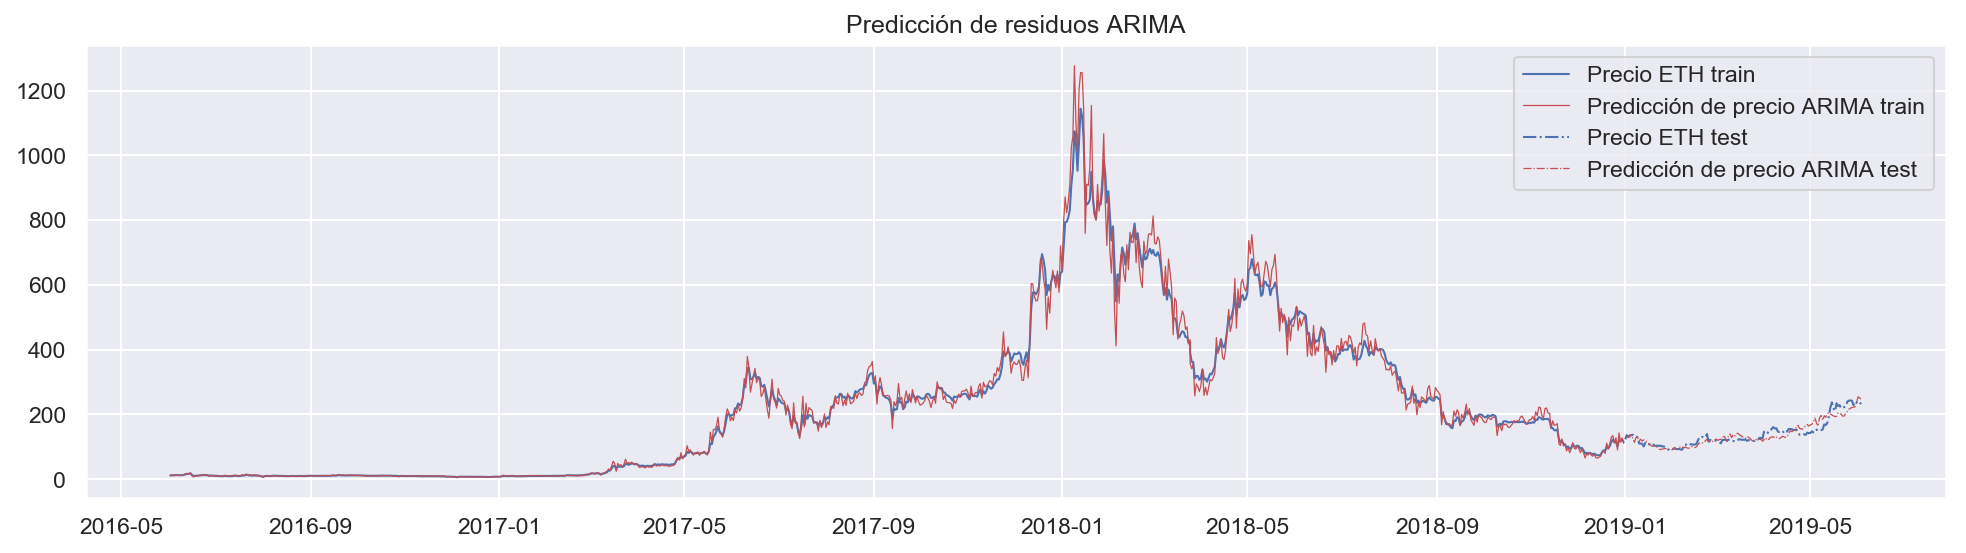

In [389]:
fully_recovered_eth_train = 10**restaured_train_residual_predictions
fully_recovered_eth_test  = 10**restaured_test_residual_predictions

# Plot of predicted values
plt.figure(figsize=(16, 4))
plt.plot(ETH_train_serie, color='b', linewidth=1)
plt.plot(ETH_train_index, fully_recovered_eth_train, color='r', linewidth=0.6, linestyle='-')
plt.plot(ETH_test_serie, color='b', linewidth=1, linestyle='-.')
plt.plot(ETH_test_index, fully_recovered_eth_test, color='r', linewidth=0.6, linestyle='-.')
plt.legend(['Precio ETH train', 'Predicción de precio ARIMA train', 'Precio ETH test','Predicción de precio ARIMA test'])
plt.title('Predicción de residuos ARIMA')
plt.show()